<a href="https://colab.research.google.com/github/Meisam-Heidari/reCLAIM-2019-Competition/blob/master/ReClaim_Regression_Submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import and Set-Up

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TF 2.0
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


# ML Models 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import naive_bayes
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

#  Model Optimization
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV

#ToSaveModels
import pickle


TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


# Classification DataSet

## Loading

In [0]:
test_set = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Header - test.txt")
df_clas_header_train = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Header - train.txt")
df_clas_header_validation = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Header - validation.txt")
df_clas_well_class_train = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Well_class_train.txt")
df_clas_well_class_validation = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Well_class_validate.txt")

In [0]:
#test_set = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Header - test.txt")


# Merge Data

In [0]:
df_clas_well_class_train['EPAssetsId'].duplicated().sum(), df_clas_header_train['EPAssetsId'].duplicated().sum()

(0, 0)

In [0]:
df_train = pd.merge(df_clas_well_class_train, df_clas_header_train, on = ['EPAssetsId','EPAssetsId'] )
df_validation = pd.merge(df_clas_well_class_validation, df_clas_header_validation, on = ['EPAssetsId','EPAssetsId'] )
df_train = pd.concat([df_train, df_validation], ignore_index=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 92 columns):
EPAssetsId                 720804 non-null int64
well_status                720804 non-null object
well_status_code           720804 non-null int64
Province                   720804 non-null object
LicenceNumber              720804 non-null object
UWI                        720803 non-null object
CurrentOperator            720804 non-null object
CurrentOperatorParent      720804 non-null int64
CurrentOperatorID          152031 non-null float64
Licensee                   720804 non-null object
LicenseeParentCompany      720804 non-null int64
LicenseeID                 10568 non-null float64
LicenceDate                720790 non-null object
WellType                   720804 non-null object
WellTypeStandardised       720804 non-null object
ConfidentialReleaseDate    379975 non-null object
SurfAbandonDate            185090 non-null object
WellName                   720240 non-null

# Feature Selection

In [0]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',92)

In [0]:
def col_compare(first_col, second_col):
  first_col_unique = list(first_col.unique())
  second_col_unique = list(second_col.unique())
  only_in_first = []
  only_in_second = []
  for i in first_col_unique:
    if i not in second_col_unique:
      only_in_first.append((i,(first_col==i).sum()))
  for i in second_col_unique:
    if i not in first_col_unique:
      only_in_second.append((i,(second_col==i).sum()))
  return[only_in_first,only_in_second]


In [0]:
def drop_rows(df_first, df_second, column_to_check):
  [only_in_first,_] = col_compare(df_first[column_to_check],df_second[column_to_check])
  only_in_first = pd.DataFrame(only_in_first, columns=(['MissingValue','Count']))

  df_first.drop(df_first[df_first[column_to_check].isin(list(only_in_first['MissingValue'].unique()))].index, inplace = True)
  return 

In [0]:
df_train.Pool.nunique(),test_set.Pool.nunique()

(11917, 5633)

In [0]:
drop_rows(df_train,test_set,'CurrentOperatorParent')
drop_rows(df_train,test_set,'WellTypeStandardised')
drop_rows(df_train,test_set,'PSACAreaCode')

len(df_train)

719391

In [0]:
drop_rows(df_train,test_set,'Pool')

len(df_train)

704329

In [0]:
[only_in_train,only_in_test] = col_compare(df_train['Pool'], test_set['Pool'])
only_in_test = pd.DataFrame(only_in_test, columns = ["Label","Counts"])
len(only_in_test), only_in_test.Counts.sum()

(734, 763)

In [0]:
df_train.Pool.nunique(),test_set.Pool.nunique()

(4899, 5633)

## Lessons Learned from comparing Test and Training sets
- there are 734 Pools in testdata which are not present in training data. Togetehr they have 763 wells in them and are considered to be amonge the tiny pool---> Categorize them as tiny for prediction
- There are 6284 pool names in train dataset which are noty present in test dataset with 15062 wells in them. They are dropped to make the model training releavant.

- If at some point, Pool is not used in the model built procedure, all rows that are dropped from training dataset must come back.

## 2nd attempt at feature sellection
The model was able to acheive 83% acuracy on traning and test data. To improve lets select more features.

In [0]:
df_train['well_status'].value_counts()

Abandoned    300639
Active       279321
Suspended    124369
Name: well_status, dtype: int64

In [0]:
# CurrentOperatorParent
# Use it: think about grouping and merging
Parent_df = pd.DataFrame([df_train[df_train['well_status']=='Suspended']['CurrentOperatorParent'].value_counts(),
                   df_train[df_train['well_status']=='Active']['CurrentOperatorParent'].value_counts(),
                   df_train[df_train['well_status']=='Abandoned']['CurrentOperatorParent'].value_counts(),
              df_train['CurrentOperatorParent'].value_counts()], index = ['Suspended','Active', 'Abandoned','Counts']).transpose().sort_values('Counts', ascending = False)
Parent_df['Counts'].sum()

704329.0

In [0]:
# CurrentOperatorParent
test_set_Parent_df = pd.DataFrame([test_set['CurrentOperatorParent'].value_counts()], index = ['Counts']).transpose().sort_values('Counts', ascending = False)
test_set_Parent_df['Counts'].sum()

118076

In [0]:
tiny_co_list= list(Parent_df[Parent_df['Counts']<100].index)
small_co_list= list(Parent_df[(Parent_df['Counts']<1000) & (Parent_df['Counts']>=100)].index)
mid_co_list = list(Parent_df[(Parent_df['Counts']<5000) & (Parent_df['Counts']>=1000)].index)
large_co_list = list(Parent_df[Parent_df['Counts']>=5000].index)


In [0]:
test_tiny_co_list= list(test_set_Parent_df[test_set_Parent_df['Counts']<100].index)
test_small_co_list= list(test_set_Parent_df[(test_set_Parent_df['Counts']<1000) & (test_set_Parent_df['Counts']>=100)].index)
test_mid_co_list = list(test_set_Parent_df[(test_set_Parent_df['Counts']<5000) & (test_set_Parent_df['Counts']>=1000)].index)
test_large_co_list = list(test_set_Parent_df[test_set_Parent_df['Counts']>=5000].index)


In [0]:
[len(tiny_co_list), len(small_co_list), len(mid_co_list),len(large_co_list),'<Trainig-Testing>', len(test_tiny_co_list), len(test_small_co_list) ,len(test_mid_co_list),len(test_large_co_list)]

[474, 119, 45, 16, '<Trainig-Testing>', 606, 68, 10, 2]

In [0]:
#Lets Creat a new columns with only the major Parent IDs
tiny_co_list = dict.fromkeys(tiny_co_list,'Tiny_Co')
small_co_list = dict.fromkeys(small_co_list,'Small_Co')
mid_co_list = dict.fromkeys(mid_co_list,'Mid_Co')
#large_co_list = dict.fromkeys(large_co_list,'Large_Co')

test_tiny_co_list = dict.fromkeys(test_tiny_co_list,'Tiny_Co')


df_train['Cur_Op_Par_size'] = df_train['CurrentOperatorParent'].replace(tiny_co_list).replace(small_co_list)
test_set['Cur_Op_Par_size'] = test_set['CurrentOperatorParent'].replace(tiny_co_list).replace(small_co_list).replace(test_tiny_co_list)
df_train['Cur_Op_Par_size'].nunique(),test_set['Cur_Op_Par_size'].nunique()

(63, 63)

''

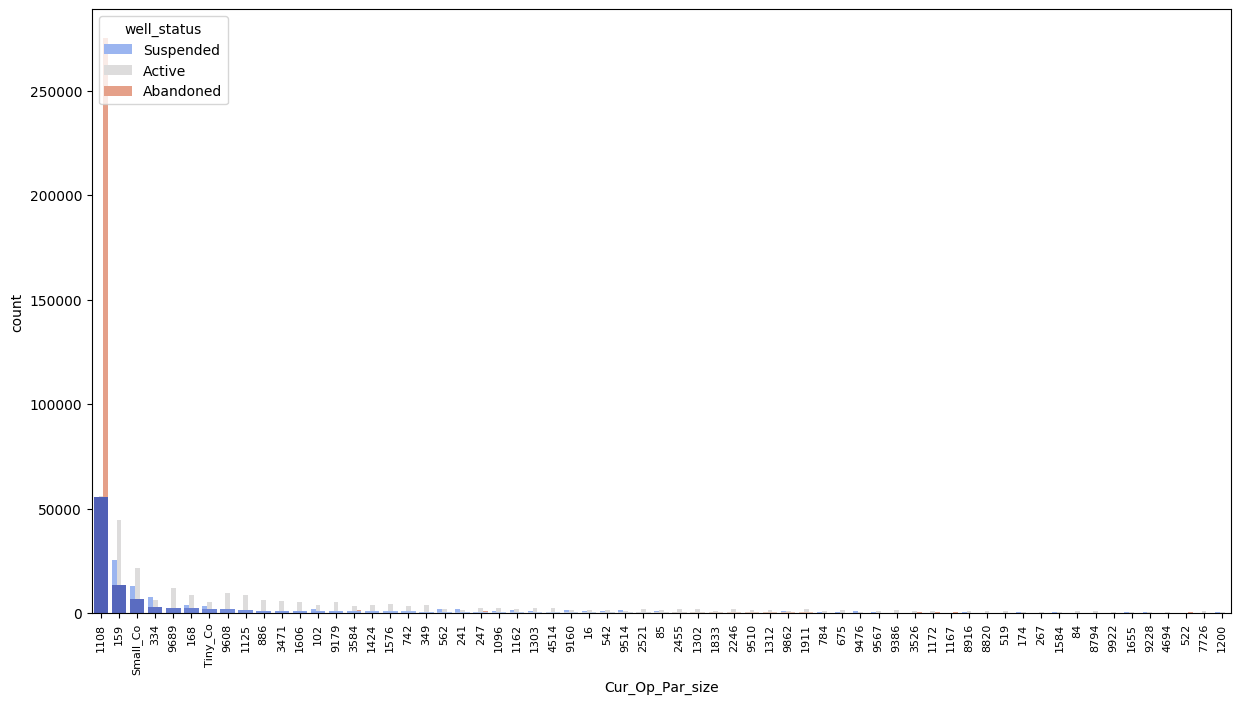

In [0]:
# Worked! Use it.
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=100, figsize = [14.7,8])
sns.countplot(df_train['Cur_Op_Par_size'], order = df_train['Cur_Op_Par_size'].value_counts().
              index  , hue=df_train['well_status'], palette ='coolwarm')
sns.countplot(test_set['Cur_Op_Par_size'], order = df_train['Cur_Op_Par_size'].value_counts().
              index  , palette ='coolwarm')
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 8)
;

In [0]:
# WellTypeStandardised
# Use it. Groupe it first
pd.DataFrame([df_train[df_train['well_status']=='Suspended']['WellTypeStandardised'].value_counts()/106314,
                   df_train[df_train['well_status']=='Active']['WellTypeStandardised'].value_counts()/234232,
                   df_train[df_train['well_status']=='Abandoned']['WellTypeStandardised'].value_counts()/248127], index = ['Suspended','Active', 'Abandoned']).transpose().sort_values('Suspended', ascending = False).head(30)

,Suspended,Active,Abandoned
Oil,0.391943,0.306713,0.233276
Gas,0.382922,0.428490,0.181653
Unspecified,0.190398,0.018191,0.510638
Bitumen,0.080827,0.030739,0.035268
Injection - Water,0.028548,0.042881,0.015069
Commingled - Oil,0.014344,0.000324,0.000923
Commingled - Gas,0.014137,0.000013,0.000161
Oil Sands Evaluation,0.012077,0.004030,0.141548
Coalbed Methane,0.007704,0.077628,0.001314
Disposal - Water,0.007403,0.009879,0.004607


In [0]:
# Seem to work but I am going to try it again in 3rd attempt (further down) to see if I can bring more granuality 
Commingled = dict.fromkeys(['Commingled - Water','Commingled Injection - Water','Commingled Observation',
                   'Commingled Disposal - Water','Commingled Bitumen'], 'Commingled')
Disposal = dict.fromkeys(['Disposal - Gas','Disposal - Brine','Disposal - Waste','Disposal - Acid Gas',
                          'Disposal - Water','Disposal - Salt Water','Commingled Disposal - Water','Salt Water',
                          'Industrial Waste'], 'Disposal')
Injection = dict.fromkeys(['Injection - Unspecified','Injection - Salt Water','Injection - Gas','Injection - Solvent',
                           'Injection - Nitrogen','Injection - Steam','Injection - Water','Injection - CO2',
                           'Injection - Air (Combustion)','Injection - Oxygen',''], 'Injection')
SAGD_Polymer = dict.fromkeys(['Commingled Injection - Steam','Injection - Water Alternating Gas','SAGD',
                              'Oil - Cyclical','Injection - Polymer',''],'SAGD_Polymer')       
Other_Waters = dict.fromkeys(['Farm Water','Source Water','Water Source','Domestic Water'],'Other_Waters')
Test = dict.fromkeys(['Experimental','Test Hole','Stratigraphic Test','Test', 'Training',
                              'Evaluation','Oil Sands Evaluation','Injetcion - Polymer'],'Test_Hole')
Confidential = dict.fromkeys(['Potash','Confidential'],'Confidential')

df_train['My_Well_Types'] = df_train['WellTypeStandardised'].replace('Commingled - Oil','Commingled Oil'
).replace('Commingled - Gas','Commingled Gas').replace('Commingled Coalbed Methane','Commingled Gas'
).replace('Disposal - Unspecified','Unspecified').replace('Development Service Well','Unspecified'
).replace('Oil & Gas','Oil').replace('Crude Oil Observation', 'Observation').replace('Farm Gas','Gas'
).replace('Storage - LPG','Gas').replace('Storage - Gas','Commingled Gas')

df_train['My_Well_Types'] = df_train['My_Well_Types'] .replace(Commingled
                                                                            ).replace(Disposal
                                                                                      ).replace(SAGD_Polymer
                                                                                                ).replace(Injection
                                                                                                          ).replace(Test
                                                                                                                    ).replace(Other_Waters
                                                                                                                              ).replace(Confidential)

df_train['My_Well_Types'].nunique()

19

In [0]:
# Test data has one extra lable in it with 1 well only 'Injection - Water Alt', added to injection category
Commingled = dict.fromkeys(['Commingled - Water','Commingled Injection - Water','Commingled Observation',
                   'Commingled Disposal - Water','Commingled Bitumen'], 'Commingled')
Disposal = dict.fromkeys(['Disposal - Gas','Disposal - Brine','Disposal - Waste','Disposal - Acid Gas',
                          'Disposal - Water','Disposal - Salt Water','Commingled Disposal - Water','Salt Water',
                          'Industrial Waste'], 'Disposal')
Injection = dict.fromkeys(['Injection - Unspecified','Injection - Salt Water','Injection - Gas','Injection - Solvent',
                           'Injection - Nitrogen','Injection - Steam','Injection - Water','Injection - CO2',
                           'Injection - Air (Combustion)','Injection - Oxygen','Injection - Water Alt'], 'Injection')
SAGD_Polymer = dict.fromkeys(['Commingled Injection - Steam','Injection - Water Alternating Gas','SAGD',
                              'Oil - Cyclical','Injection - Polymer',''],'SAGD_Polymer')       
Other_Waters = dict.fromkeys(['Farm Water','Source Water','Water Source','Domestic Water'],'Other_Waters')
Test = dict.fromkeys(['Experimental','Test Hole','Stratigraphic Test','Test', 'Training',
                              'Evaluation','Oil Sands Evaluation','Injetcion - Polymer'],'Test_Hole')
Confidential = dict.fromkeys(['Potash','Confidential'],'Confidential')

test_set['My_Well_Types'] = test_set['WellTypeStandardised'].replace('Commingled - Oil','Commingled Oil'
).replace('Commingled - Gas','Commingled Gas').replace('Commingled Coalbed Methane','Commingled Gas'
).replace('Disposal - Unspecified','Unspecified').replace('Development Service Well','Unspecified'
).replace('Oil & Gas','Oil').replace('Crude Oil Observation', 'Observation').replace('Farm Gas','Gas'
).replace('Storage - LPG','Gas').replace('Storage - Gas','Commingled Gas')

test_set['My_Well_Types'] = test_set['My_Well_Types'] .replace(Commingled
                                                                            ).replace(Disposal
                                                                                      ).replace(SAGD_Polymer
                                                                                                ).replace(Injection
                                                                                                          ).replace(Test
                                                                                                                    ).replace(Other_Waters
                                                                                                                              ).replace(Confidential)

test_set['My_Well_Types'].nunique()

19

In [0]:
[only_in_first,_] = col_compare(test_set['My_Well_Types'],df_train['My_Well_Types'])
only_in_first

[]

''

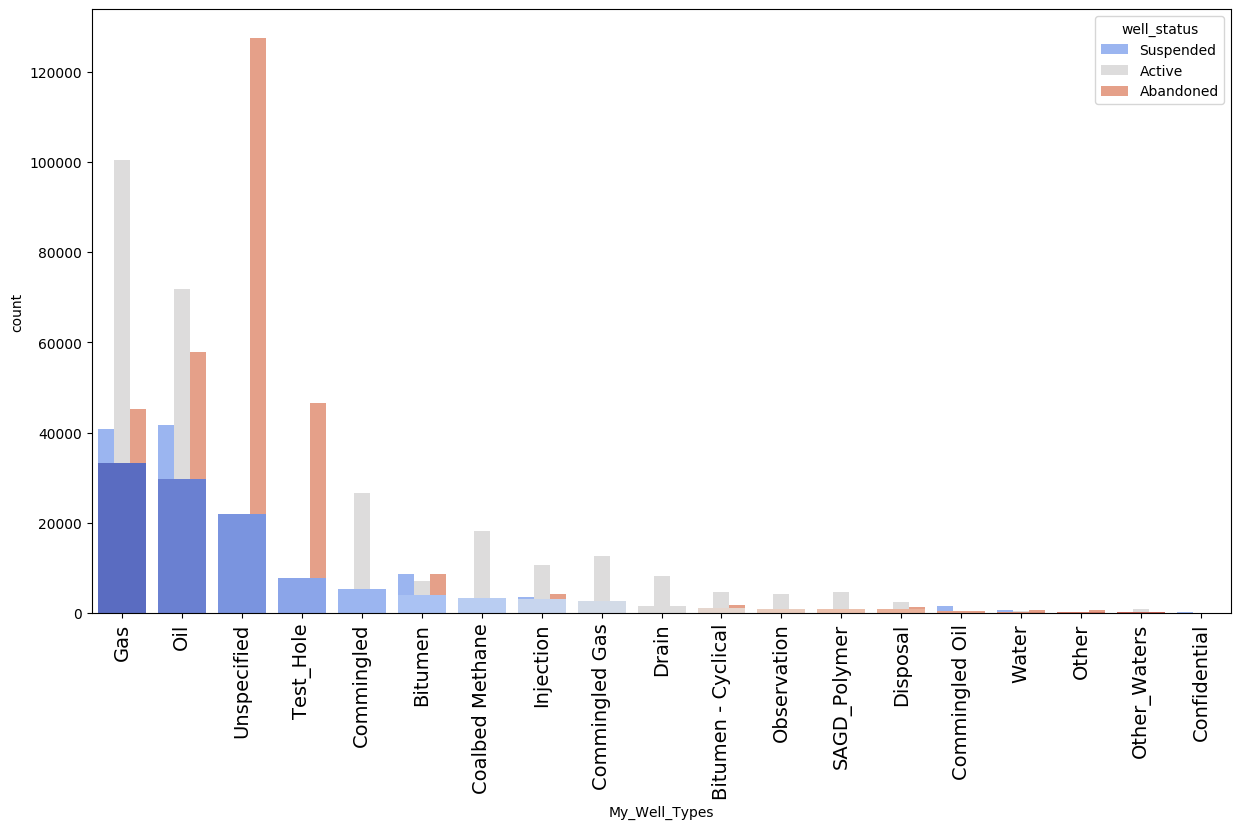

In [0]:
# Looks Great lets use it
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=100, figsize = [14.7,8])
sns.countplot(df_train['My_Well_Types'], order = df_train['My_Well_Types'].value_counts().
              index  , hue=df_train['well_status'], palette ='coolwarm')
sns.countplot(test_set['My_Well_Types'], order = df_train['My_Well_Types'].value_counts().
              index  , palette ='coolwarm')
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 14)
;

## Above Data applyes to ML Attempt 3 and 4. 



## 3rd Attempt at feature sellection

In [0]:
Disposal_Water = dict.fromkeys(['Commingled Disposal - Water','Disposal - Brine','Disposal - Salt Water'], 'Disposal - Water')
Injection_Water = dict.fromkeys(['Commingled Injection - Water','Injection - Salt Water'], 'Injection - Water')

SAGD = dict.fromkeys(['Injection - Water Alternating Gas','Injection - Polymer',
                              'Oil - Cyclical'],'SAGD')       

Test_Hole = dict.fromkeys(['Test','Experimental'],'Test Hole')

Commingled_OG = dict.fromkeys(['Commingled - Gas','Commingled - Oil'],'Commingled_OG')

Drain = dict.fromkeys(['Domestic Water','Water Source','Source Water','Farm Water'],'Drain')

Other_Smalls = dict.fromkeys(['Injection - Oxygen','Commingled Injection - Steam','Crude Oil Observation',
                              'Commingled Observation','Commingled Bitumen','Injection - Nitrogen','Oil & Gas',
                              'Disposal - Gas','Injetcion - Polymer','Training','Industrial Waste','Commingled - Water',
                              'Disposal - Acid Gas','Salt Water','Evaluation','Storage - LPG','Farm Gas',
                              'Stratigraphic Test','Potash','Confidential','Disposal - Waste','Storage - Gas',
                              'Injection - Unspecified','Water','Injection - Steam','Injection - CO2','Injection - Gas',
                              'Injection - Solvent','Other','Development Service Well'],'Other_Smalls')

df_train['My_Well_Types'] = df_train['WellTypeStandardised'].replace('Injection - Air (Combustion)','Unspecified'
).replace('Disposal - Unspecified','Unspecified').replace('Commingled Oil','Commingled').replace('Commingled Coalbed Methane','Coalbed Methane')

df_train['My_Well_Types'] = df_train['My_Well_Types'] .replace(Disposal_Water
                                                               ).replace(Injection_Water).replace(SAGD).replace(Commingled_OG)

df_train['My_Well_Types'] = df_train['My_Well_Types'] .replace(Test_Hole).replace(Other_Smalls).replace(Drain)
df_train['My_Well_Types'] = df_train['My_Well_Types'] .replace(' ','_').replace('-','')
df_train['My_Well_Types'].nunique()

17

In [0]:
# WellTypeStandardised
My_well_type_df = pd.DataFrame([df_train[df_train['well_status']=='Suspended']['My_Well_Types'].value_counts(),
                   df_train[df_train['well_status']=='Active']['My_Well_Types'].value_counts(),
                   df_train[df_train['well_status']=='Abandoned']['My_Well_Types'].value_counts()], index = ['Suspended','Active', 'Abandoned']).transpose()
My_well_type_df.fillna(value=0,inplace=True)
My_well_type_df['Well_Count']= My_well_type_df['Abandoned']+My_well_type_df['Active']+My_well_type_df['Suspended']
My_well_type_df.sort_values('Well_Count', inplace = True, ascending=False)


In [0]:
My_well_type_df['Supended_ratio'] = My_well_type_df['Suspended']/My_well_type_df['Well_Count']
My_well_type_df['Active_ratio'] = My_well_type_df['Active']/My_well_type_df['Well_Count']
My_well_type_df['Abandoned_ratio'] = My_well_type_df['Abandoned']/My_well_type_df['Well_Count']
My_well_type_df.sort_values('Supended_ratio', inplace = True, ascending=False)

''

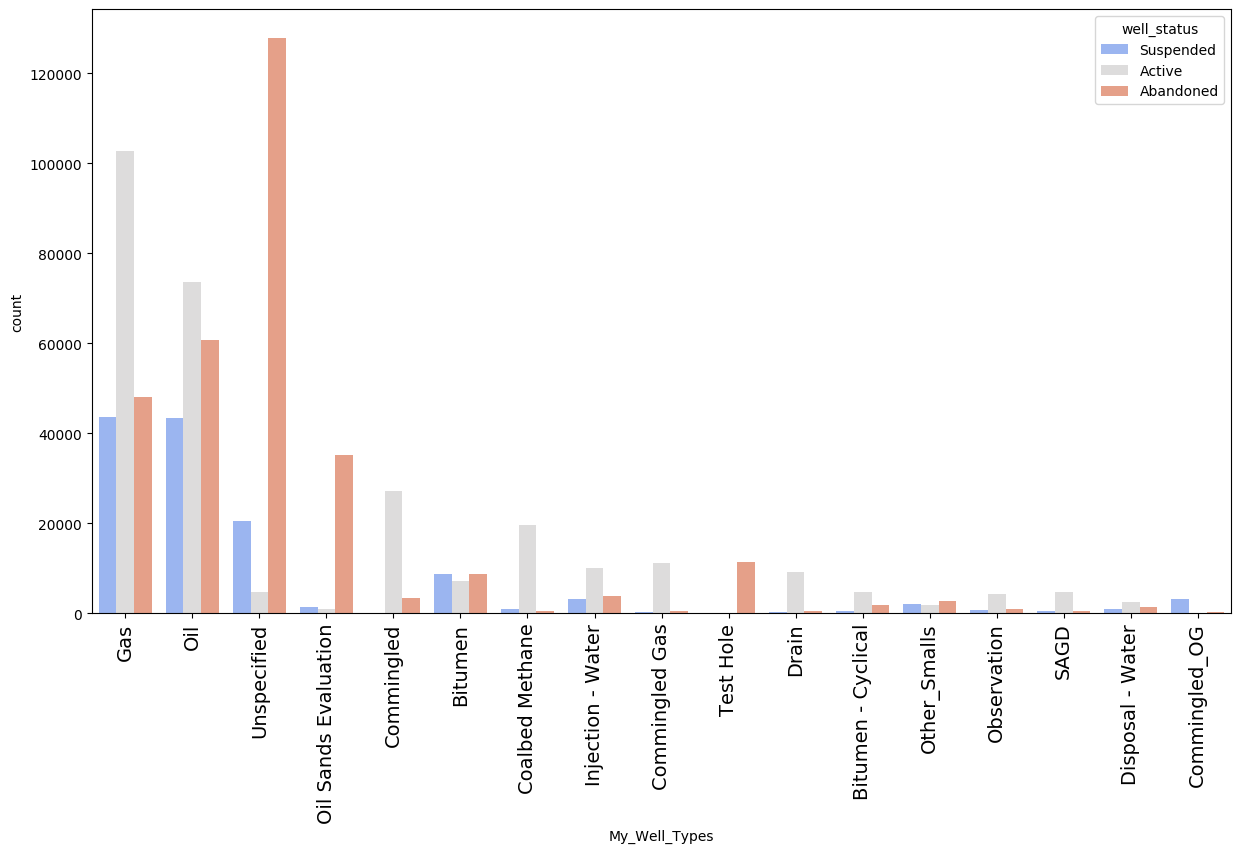

In [0]:

fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=100, figsize = [14.7,8])
sns.countplot(df_train['My_Well_Types'], order = df_train['My_Well_Types'].value_counts().
              index  , hue=df_train['well_status'], palette ='coolwarm')
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 14)
;


In [0]:
My_well_type_df

,Suspended,Active,Abandoned,Well_Count,Supended_ratio,Active_ratio,Abandoned_ratio
Commingled_OG,3041,80,271,3392,0.896521,0.023585,0.079894
Bitumen,8603,7203,8751,24557,0.350328,0.293318,0.356355
Other_Smalls,2114,1876,2773,6763,0.312583,0.277392,0.410025
Oil,43389,73567,60602,177558,0.244365,0.414327,0.341308
Gas,43539,102806,48038,194383,0.223986,0.528884,0.247131
Injection - Water,3084,10099,3780,16963,0.181807,0.595355,0.222838
Disposal - Water,833,2505,1281,4619,0.180342,0.542325,0.277333
Unspecified,20422,4635,127859,152916,0.133550,0.030311,0.836139
Observation,613,4293,873,5779,0.106074,0.742862,0.151064
SAGD,490,4646,369,5505,0.089010,0.843960,0.067030


### Lets categorize Pools, and compare Lisensee with Operator

In [0]:
df_train['Pool'].value_counts()[:10]

Unspecified             208145
Commingled MFP9501       84778
Commingled Pool 001      14522
Not Available            13579
Wabiskaw-Mcmurray        12413
Lower Grand Rapids        9543
Temporary Commingled      8348
Commingled MFP9529        8279
Clearwater                7228
Cardium                   7135
Name: Pool, dtype: int64

In [0]:
df_train['Pool'].value_counts().describe()


count     11917.000000
mean         60.462197
std        2084.028167
min           1.000000
25%           1.000000
50%           2.000000
75%           9.000000
max      208145.000000
Name: Pool, dtype: float64

In [0]:
# Use it: think about grouping and merging
df_pools = pd.DataFrame([df_train[df_train['well_status']=='Suspended']['Pool'].value_counts(),
                   df_train[df_train['well_status']=='Active']['Pool'].value_counts(),
                   df_train[df_train['well_status']=='Abandoned']['Pool'].value_counts(),
              df_train['Pool'].value_counts()], index = ['Suspended','Active', 'Abandoned','Counts']).transpose().sort_values('Counts', ascending = False)
df_pools['Counts'].sum()

720528.0

In [0]:
df_pools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11917 entries, Unspecified to Rock Creek Z6Z
Data columns (total 4 columns):
Suspended    6836 non-null float64
Active       6683 non-null float64
Abandoned    7869 non-null float64
Counts       11917 non-null float64
dtypes: float64(4)
memory usage: 465.5+ KB


In [0]:
tiny_pool_list= list(df_pools[df_pools['Counts']<100].index)
small_pool_list= list(df_pools[(df_pools['Counts']<1000) & (df_pools['Counts']>=100)].index)
mid_pool_list = list(df_pools[(df_pools['Counts']<10000) & (df_pools['Counts']>=1000)].index)
large_pool_list = list(df_pools[df_pools['Counts']>=10000].index)


In [0]:
len(tiny_pool_list), len(small_pool_list), len(mid_pool_list),len(large_pool_list)

(11339, 514, 59, 5)

In [0]:
#Lets Creat a new columns with only the major Parent IDs
tiny_pool_list = dict.fromkeys(tiny_pool_list,'Tiny_Pools')
small_pool_list = dict.fromkeys(small_pool_list,'Small_Pools')
mid_pool_list = dict.fromkeys(mid_pool_list,'Mid_Pools')


df_train['Smpl_pool'] = df_train['Pool'].replace(tiny_pool_list).replace(small_pool_list).replace(mid_pool_list).replace(mid_pool_list)

df_train['Smpl_pool'].nunique()

8

In [0]:
df_train['Smpl_pool'].describe()

count          720528
unique              8
top       Unspecified
freq           208145
Name: Smpl_pool, dtype: object

In [0]:
df_train['Smpl_pool'].unique()

array(['Small_Pools', 'Mid_Pools', 'Unspecified', 'Tiny_Pools',
       'Commingled MFP9501', 'Wabiskaw-Mcmurray', 'Commingled Pool 001',
       'Not Available', nan], dtype=object)

In [0]:
df_train.groupby('Smpl_pool') ['well_status'].value_counts()

Smpl_pool            well_status
Commingled MFP9501   Active          71970
                     Abandoned        7607
                     Suspended        5201
Commingled Pool 001  Active           7295
                     Suspended        3734
                     Abandoned        3493
Mid_Pools            Active          91922
                     Abandoned       36654
                     Suspended       31252
Not Available        Abandoned       13291
                     Suspended         207
                     Active             81
Small_Pools          Active          58015
                     Abandoned       42266
                     Suspended       35323
Tiny_Pools           Abandoned       33145
                     Active          31502
                     Suspended       27012
Unspecified          Abandoned      167962
                     Suspended       24291
                     Active          15892
Wabiskaw-Mcmurray    Active           7536
                     

''

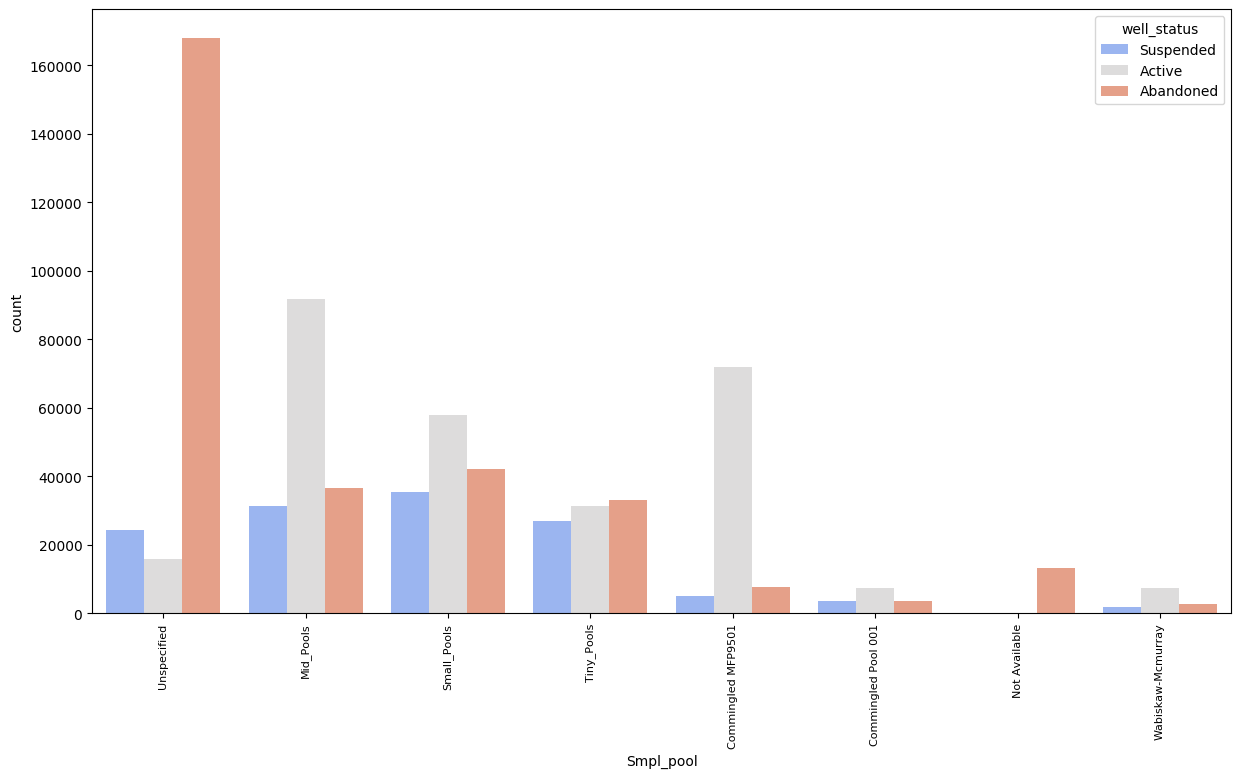

In [0]:
# Worked! Use it.
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=100, figsize = [14.7,8])
sns.countplot(df_train['Smpl_pool'], order = df_train['Smpl_pool'].value_counts().
              index  , hue=df_train['well_status'], palette ='coolwarm')
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 8)
;

In [0]:
df_train['CurrentOperator'].nunique(), df_train['Licensee'].nunique()

(1543, 4655)

In [0]:
sum(df_train['CurrentOperator']==df_train['Licensee']), sum(df_train['CurrentOperator']!=df_train['Licensee'])

(301305, 419499)

In [0]:
df_train['Operator_is_Licensee'] = (df_train['CurrentOperator']==df_train['Licensee']).replace(True, 1).replace(False, 0)
sum(df_train['Operator_is_Licensee'])

301305.0

''

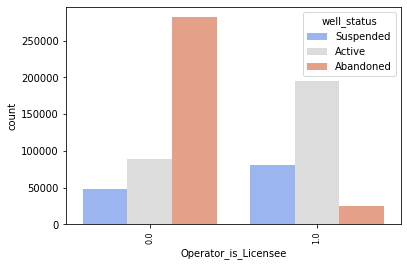

In [0]:
# Worked! Use it.
fig1,axes=plt.subplots(nrows=1,ncols=1)
sns.countplot(df_train['Operator_is_Licensee'], order = df_train['Operator_is_Licensee'].value_counts().
              index  , hue=df_train['well_status'], palette ='coolwarm')
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 8)
;

# Basic Cleaning: Columns to drop

In [0]:
# List of columns with too many null values: must be dropped
null_cols_to_drop = list(df_train.isnull().sum()[df_train.isnull().sum()>450000].index)
null_cols_to_drop

['CurrentOperatorID',
 'LicenseeID',
 'SurfAbandonDate',
 'UnitID',
 'UnitName',
 'Municipality',
 'CompletionDate',
 '_Max`Prod`(BOE)',
 '_Fracture`Stages',
 '_Completion`Events']

### Keep Fracture, Events and Max BOE Columns

In [0]:
null_cols_to_drop.remove('_Completion`Events')
null_cols_to_drop.remove('_Fracture`Stages')
null_cols_to_drop.remove('_Max`Prod`(BOE)')
null_cols_to_drop.remove('SurfAbandonDate')


null_cols_to_drop

['CurrentOperatorID',
 'LicenseeID',
 'UnitID',
 'UnitName',
 'Municipality',
 'CompletionDate']

## Colomns with similarities to drop

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 0 to 720803
Data columns (total 94 columns):
EPAssetsId                 704329 non-null int64
well_status                704329 non-null object
well_status_code           704329 non-null int64
Province                   704329 non-null object
LicenceNumber              704329 non-null object
UWI                        704328 non-null object
CurrentOperator            704329 non-null object
CurrentOperatorParent      704329 non-null int64
CurrentOperatorID          150551 non-null float64
Licensee                   704329 non-null object
LicenseeParentCompany      704329 non-null int64
LicenseeID                 9925 non-null float64
LicenceDate                704315 non-null object
WellType                   704329 non-null object
WellTypeStandardised       704329 non-null object
ConfidentialReleaseDate    368427 non-null object
SurfAbandonDate            181764 non-null object
WellName                   703792 non-null 

In [0]:
useless_cols = ['UWI',
                'WellType',
 'ConfidentialReleaseDate',
 'WellName',
 'SurveySystem',
 'Surf_Location',
 'Surf_Township',
 'Surf_Meridian',
 'Surf_Range',
 'Surf_Section',
 'Surf_LSD',
 'Surf_Longitude',
 'Surf_Latitude',
 'Surf_TownshipRange',
 'Surf_QuarterUnit',
 'Surf_Unit',
 'Surf_Block',
 'Surf_NTSMapSheet',
 'Surf_Series',
 'Surf_Area',
 'Surf_Sheet',
 'Surf_QuarterSection',
 'BH_Location',
 'BH_TownshipRange',
 'BH_QuarterUnit',
 'BH_Unit',
 'BH_Block',
 'BH_NTSMapSheet',
 'BH_Series',
 'BH_Area',
 'BH_Sheet',
 'BH_QuarterSection',
 'BH_Longitude',
 'BH_Latitude',
 'BH_Township',
 'BH_Meridian',
 'BH_Range',
 'BH_Section',
 'BH_LSD',
 'GroundElevation',
 'KBElevation',
 'SurfaceOwner',
 'DrillingContractor',
 'DrillMetresPerDay',
 'Country',
 'RegulatoryAgency',
 'NumberofWells',
 'ProjectedDepth',
 'StatusSource',
 'UnitID',
 'UnitName',
 'UnitFlag',
 'Municipality',
 'CompletionDate',
 'Agent']
useless_cols[0],useless_cols[len(useless_cols)-1]

('UWI', 'Agent')

In [0]:
overlaping_cols_to_drop =[
 'CurrentOperator',
 'CurrentOperatorParent',
 'Licensee',
 'LicenseeParentCompany',
 'WellType',
 'WellName',
 'OSArea']

In [0]:
# Now that we have our lists, Lets ddrop the columns

for i in range(len(overlaping_cols_to_drop)):
    if overlaping_cols_to_drop[i] in list(df_train.columns):
        df_train.drop(overlaping_cols_to_drop[i], axis = 1, inplace=True)

for i in range(len(useless_cols)):
    if useless_cols[i] in list(df_train.columns):
        df_train.drop(useless_cols[i], axis = 1, inplace=True)
        
for i in range(len(null_cols_to_drop)):
    if null_cols_to_drop[i] in list(df_train.columns):
        df_train.drop(null_cols_to_drop[i], axis = 1, inplace=True)
        
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 0 to 720803
Data columns (total 32 columns):
EPAssetsId              704329 non-null int64
well_status             704329 non-null object
well_status_code        704329 non-null int64
Province                704329 non-null object
LicenceNumber           704329 non-null object
LicenceDate             704315 non-null object
WellTypeStandardised    704329 non-null object
SurfAbandonDate         181764 non-null object
WellNameAmended         703792 non-null object
Formation               704329 non-null object
Field                   704329 non-null object
Pool                    704053 non-null object
TotalDepth              696884 non-null float64
LaheeClass              704329 non-null object
Confidential            704329 non-null object
OSDeposit               669309 non-null object
SpudDate                675575 non-null object
FinalDrillDate          648024 non-null object
RigReleaseDate          553992 non-null obje

# Export DataFile

In [0]:
#Maybe not required to have it again
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
ls

'My Drive'/


In [0]:
%cd /gdrive/My Drive/PythonExports


/gdrive/My Drive/PythonExports


In [0]:
#d = {'col1': [1, 2], 'col2': [3, 4]}
#MyDF = pd.DataFrame(data=d)

In [0]:
#MyDF.to_csv('YourDF.csv')

In [0]:
#!cp Basic_Columns_dropped.csv /content/drive/My\ Drive/reCLAIM\ 2019\ Competition/classification_comp_starter_kit/

In [0]:
df_train.to_csv('training_basic_clean_RF_BaseModel.csv')
test_set.to_csv('test_basic_clean_RF_BaseModel.csv')

#Create Dates and Time differences

In [0]:
df_train['LicenceDate'] = pd.to_datetime(df_train['LicenceDate'].str.split(' ', 0).str[0])
df_train['SurfAbandonDate'] = pd.to_datetime(df_train['SurfAbandonDate'].str.split(' ', 0).str[0])
df_train['FinalDrillDate'] = pd.to_datetime(df_train['FinalDrillDate'].str.split(' ', 0).str[0])
df_train['StatusDate'] = pd.to_datetime(df_train['StatusDate'].str.split(' ', 0).str[0])


In [0]:
df_train['SpudDate'] = pd.to_datetime(df_train['SpudDate'].str.split(' ', 0).str[0])
df_train['RigReleaseDate'] = pd.to_datetime(df_train['RigReleaseDate'].str.split(' ', 0).str[0])

In [0]:
# calculating the number of days between getting the license and reporting the status
Rig_release_to_Status= (df_train['StatusDate']-df_train['RigReleaseDate']).dt.days
Spud_to_rig_release = (df_train['RigReleaseDate']-df_train['SpudDate']).dt.days

Spud_to_rig_release.isnull().sum()

150366

In [0]:
df_train['Today'] = pd.Timestamp.today()
df_train['Status_to_today'] = (df_train['Today']-df_train['StatusDate']).dt.days
df_train.drop(columns=['Today','StatusDate','RigReleaseDate','LicenceDate','FinalDrillDate','SpudDate'], inplace=True)

In [0]:
df_train['Rig_release_to_Status'] = Rig_release_to_Status
df_train['Spud_to_rig_release'] = Spud_to_rig_release


In [0]:
df_train.replace('NaN',np.nan ,inplace=True)
df_train.replace('None',np.nan ,inplace=True)

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 0 to 720803
Data columns (total 30 columns):
EPAssetsId               704329 non-null int64
well_status              704329 non-null object
well_status_code         704329 non-null int64
Province                 704329 non-null object
LicenceNumber            704329 non-null object
WellTypeStandardised     704329 non-null object
SurfAbandonDate          181764 non-null datetime64[ns]
WellNameAmended          703792 non-null object
Formation                704329 non-null object
Field                    704329 non-null object
Pool                     704053 non-null object
TotalDepth               696884 non-null float64
LaheeClass               704329 non-null object
Confidential             704329 non-null object
OSDeposit                669309 non-null object
DaysDrilling             674123 non-null float64
TVD                      663003 non-null float64
WellProfile              704329 non-null object
WellSymbPt1     

In [0]:
df_train.nunique()

EPAssetsId               704329
well_status                   3
well_status_code              3
Province                      4
LicenceNumber            565798
WellTypeStandardised         59
SurfAbandonDate           23398
WellNameAmended          547533
Formation                   554
Field                      1932
Pool                       4899
TotalDepth                26954
LaheeClass                   17
Confidential                  5
OSDeposit                    13
DaysDrilling               1857
TVD                      105640
WellProfile                   5
WellSymbPt1                   5
PSACAreaCode                 15
PSACAreaName                 15
_Max`Prod`(BOE)           99799
_Fracture`Stages            133
_Open`Hole                    2
_Completion`Events          315
Cur_Op_Par_size              63
My_Well_Types                19
Status_to_today           26497
Rig_release_to_Status     14180
Spud_to_rig_release        1834
dtype: int64

# EDA and Plotting

Abandoned    307358
Active       284243
Suspended    129203
Name: well_status, dtype: int64

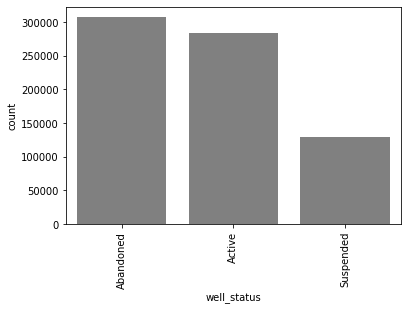

In [0]:
# univariate plots
fig1,axes=plt.subplots(nrows=1,ncols=1)
sns.countplot(df_train['well_status'], order = df_train.well_status.value_counts().
              index ,color = '0.5' )
plt.xticks(rotation = 90)
;
df_train['well_status'].value_counts()

Active       62309
Abandoned    48125
Suspended    31416
Name: well_status, dtype: int64

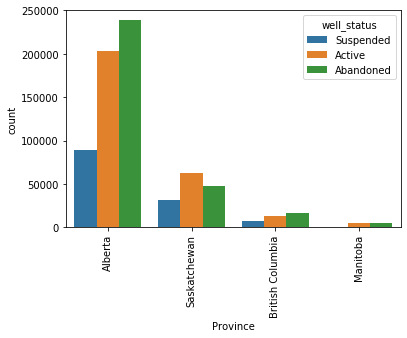

In [0]:
# univariate plots
# doesnt seemto be a good classifier, especially considering there is a finer geographical 
# classifier in PSACArea parameters
# Leave it out.
fig1,axes=plt.subplots(nrows=1,ncols=1)
sns.countplot(df_train['Province'], order = df_train.Province.value_counts().
              index , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train[df_train['Province']=='Saskatchewan']['well_status'].value_counts()

Development                 462345
New Pool Wildcat             69280
Outpost                      58134
Oil Sands Evaluation         37639
Deeper Pool Test             26562
New Field Wildcat            22632
Development Service Well     11619
Test Hole                    10858
Other                         7955
Unspecified                   6835
Re-entry                      3449
Experimental                  3044
Confidential                   411
Potash Test Hole                19
Non Issued Licence              13
Shallower Pool Test              8
Deeper Pool Wildcat              1
Name: LaheeClass, dtype: int64

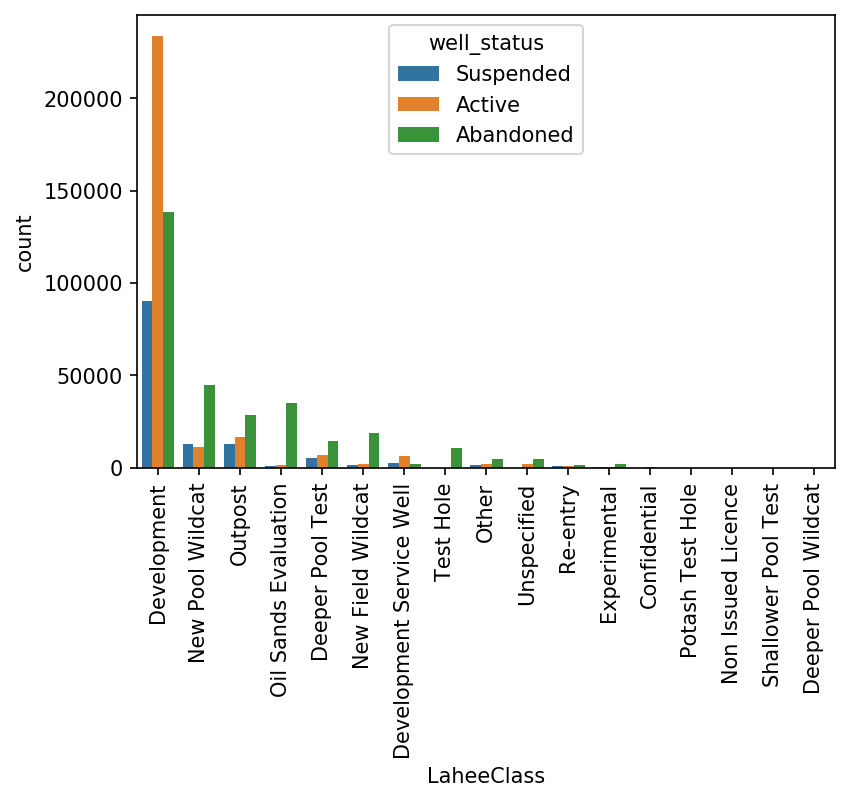

In [0]:
# univariate plots
# looks like a great identifier for abandoned wells. If the LaheeClass != Developmet, 
# there is a 64% chance that the well is abandoned
# Add 'Development Service Well' to that as well
# Use it!
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['LaheeClass'], order = df_train.LaheeClass.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
# df_train[df_train['LaheeClass']!='Development']['well_status'].value_counts()/(136095+41801+31947)
df_train['LaheeClass'].value_counts()

Active       12067
Abandoned     8065
Suspended     1763
Name: well_status, dtype: int64

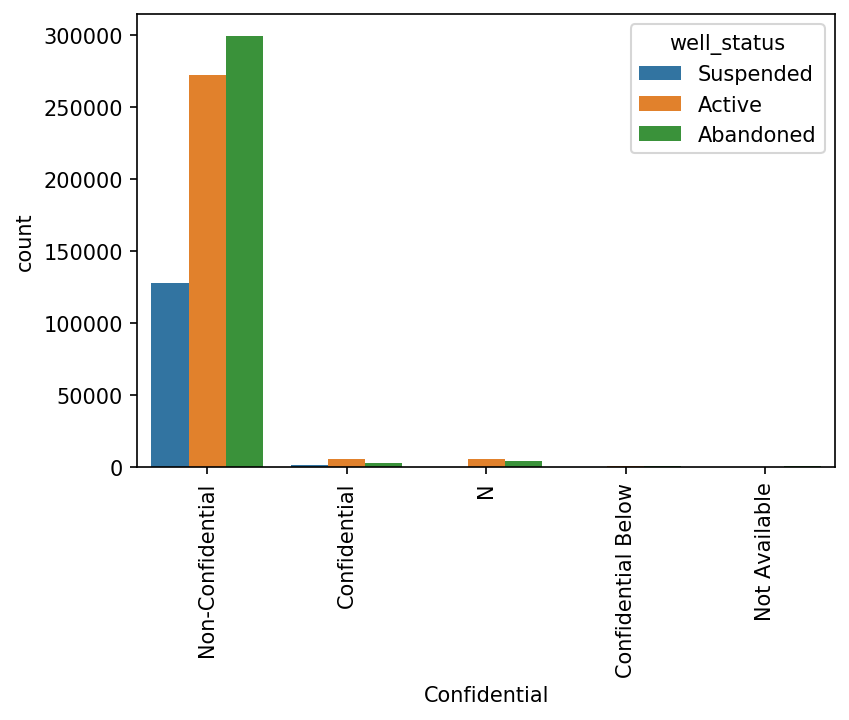

In [0]:
# univariate plots
# doesnt seem to be a good classifier. 
# leave it out
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['Confidential'], order = df_train.Confidential.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train[df_train['Confidential']!='Non-Confidential']['well_status'].value_counts()

In [0]:
# univariate plot
# OSDeposit desnt seem to be a good dummy variable. df_train['OSDeposit']!= Not Applicable has 
# too few data points. The difference in ratio of Abondoned vs Active for 2 major classes is not that
# large(data in the next 2 cells)
# leave it out!
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['OSDeposit'], order = df_train.OSDeposit.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train['OSDeposit'].value_counts()

In [0]:
df_train[df_train['OSDeposit']=='Not Applicable']['well_status'].value_counts()/(528084)


In [0]:
df_train[df_train['OSDeposit']!='Not Applicable']['well_status'].value_counts()/(588673-528084)

In [0]:
# univariate plots
# Awsome, probably need to drop last 2 categories, then use remaining 3 categories
# use it!
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['WellProfile'], order = df_train.WellProfile.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train['WellProfile'].value_counts()


In [0]:
# univariate plots
# too good to dismiss. 
# Use it!

fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['WellSymbPt1'], order = df_train.WellSymbPt1.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train['WellSymbPt1'].value_counts()

In [0]:
# univariate plots
# would be awsome to use all the categories as opposed to 0-1 dummies
# regardless, use it!

fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['PSACAreaCode'], order = df_train.PSACAreaCode.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train['PSACAreaCode'].value_counts()

In [0]:
# univariate plots
# same as 'PSACAreaCode'.
# Drop it.
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['PSACAreaName'], order = df_train.PSACAreaName.value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;
df_train['PSACAreaName'].value_counts()

In [0]:
# univariate plots
# Not good!
# leave it out.
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=150)
sns.countplot(df_train['_Open`Hole'], order = df_train['_Open`Hole'].value_counts().
              index  , hue=df_train['well_status'])
plt.xticks(rotation = 90)
;

In [0]:
# This is a good one, but needs more work to clear and create a few categories from it.
# Add it to the second phase of machin learning maybe

fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=100, figsize = [14.7,8])
sns.countplot(df_train['WellTypeStandardised'], order = df_train['WellTypeStandardised'].value_counts().
              index  , hue=df_train['well_status'], palette ='coolwarm')
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 8)
;

In [0]:
# univariate plots
# A better picture from the one above.
# 


fig1,(ax_Ab,ax_sus,ax_act) = plt.subplots(nrows=3,ncols=1,dpi=100, sharex=True, gridspec_kw={"height_ratios": (.33, .33, .34)}, figsize = [14.7,30])
sns.countplot(df_train['WellTypeStandardised'][df_train['well_status']=='Abandoned'], ax= ax_Ab, order = df_train['WellTypeStandardised'].value_counts().
              index ,orient= 'h', color = 'r' )
sns.countplot(df_train['WellTypeStandardised'][df_train['well_status']=='Suspended'], ax= ax_sus, order = df_train['WellTypeStandardised'].value_counts().
              index ,orient= 'h',color = 'g' )
sns.countplot(df_train['WellTypeStandardised'][df_train['well_status']=='Active'], ax= ax_act, order = df_train['WellTypeStandardised'].value_counts().
              index ,orient= 'h', color = 'b' )
fig1.tight_layout= True
plt.xticks(rotation = 90, fontsize = 10)
;

In [0]:
df_train['_Open`Hole'].value_counts()

In [0]:
# Total Depth may be a usefull parameter. Further investigate. 
corr = df_train.corr()
plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

In [0]:
# License number is alpha numerical, can't include it in prediction
# Leave it out.
df_train['LicenceNumber'].sample(10)

In [0]:
# seems that almost all the wells with an existing SurfAbandonDate are abandoned
# Use it.

df_train[df_train['SurfAbandonDate'].notna()]['well_status'].value_counts()

In [0]:
# it seems a large portion of abondoned wells (50% +) belong to "Unspecified" Pool category, while it has 
# a smaller role in suspended wells and even smaller one for Active wells. 
# considering more than 11,000 pool types, "Pool == Unspecified" should simplify this and 
# create a good dummy variable
# create and Use 'Pool' dummy as stated above


#---------------------
# Similar but much weaker relationship exists for Unspecified Formation. But to avoid inter-relationship between
# features, it is should not be considered
# Leave "Formation" out.
#--------------------
# Same strong relationship doesnt exist for Field names
# Leave "Field" out.


df_train[df_train['well_status']=='Abandoned']['Pool'].value_counts()/248127

In [0]:
df_train[df_train['well_status']=='Active']['Pool'].value_counts()/234232

In [0]:
df_train[df_train['well_status']=='Suspended']['Pool'].value_counts()/106314

In [0]:
# Seem extremely small TVD depth is associated with increased chance of having an abondoned well, 
# however larger TVDs dont shift the results one way or another
# it is difficult to see how this can help prediction
# test to see if it helps. 
df_train[df_train['TVD']<450]['well_status'].value_counts()/(48426+19728+7410)

In [0]:
# Seem extremely smaller well depth is associated with increased chance of having an abondoned well, while
# relatively large well depth increases chance of having an active well.
# this might overlap with having a horizontal well
# regardless, this may be one of the input features. 
# Test to see if it helps

df_train[df_train['TotalDepth']>2000]['well_status'].value_counts()

In [0]:
df_train.describe()

In [0]:
# Scatter plot of Loan Amount on Monthly Payments,for different loan Terms
#df_train['HorizontalLegnth'] =  df_train['TotalDepth']-df_train['TVD']

#sns.scatterplot(y='HorizontalLegnth',x='''_Max`Prod`(BOE)''',data=df_train[df_train['well_status']=='Abandoned'], 
#           hue = 'WellProfile')



#   axis name for the boxplot
#plt.='''Original Loan Amount(USD)''')
#axes.set(ylabel='Monthly Loan Payment (USD)')
#plt.ylim(0,5000)
#plt.xlim(0,5000);
#plt.title('''Effect of Loan Amount(USD) on Monthly Payments(USD), 
#for different loan Terms(months)'''.title(), fontsize = 14, weight = 'bold');

In [0]:
# Scatter plot of Loan Amount on Monthly Payments,for different loan Terms
#df_train['HorizontalLegnth'] =  df_train['TotalDepth']-df_train['TVD']

#sns.scatterplot(y='HorizontalLegnth',x='''well_status''',data=df_train, 
#           hue = 'WellProfile')

#   axis name for the boxplot
#plt.='''Original Loan Amount(USD)''')
#axes.set(ylabel='Monthly Loan Payment (USD)')
#plt.ylim(0,5000)
#plt.xlim(0,5000);
#plt.title('''Effect of Loan Amount(USD) on Monthly Payments(USD), 
#for different loan Terms(months)'''.title(), fontsize = 14, weight = 'bold');

In [0]:
# LoanOriginalAmount variation for each ProsperRating (numeric) category
#sns.boxplot(data=df_train, y='well_status', x='HorizontalLegnth', color='0.5')
#   axis name for the boxplot
#axes.set(ylabel='''Prosper Credit Rating("AA" is the Best, "E" is the Worst)''')
#axes.set(xlabel='Loan Original Amount(USD)')
#plt.xlim(-10,10);

In [0]:
# the effect of Days_to_StatusDate on well status does not seem to be linear. It also seems that it needs 
# more than 2 bins to help with classification
# To include it, we may need some classification work or hyper parameter tuning
# Test to see if it helps

df_train[df_train['Days_to_StatusDate']>80]['well_status'].value_counts()

In [0]:
# _Max`Prod`(BOE) seems to be great for identifying Active wells
# _Max`Prod`(BOE) notnull can be a great dummy variable to help identifying Active wells
# use it, but pleaeaeaease change the name!
df_train[df_train['''_Max`Prod`(BOE)''']>0]['well_status'].value_counts()

In [0]:
df_train[df_train['''_Max`Prod`(BOE)''']>0]['WellProfile'].value_counts()/187602

# ML Attempt 4: New Data
- Introducing Time differences, More categories in Parent ID and Well types
- 

In [0]:
df_train['HorizontalLegnth'] =  df_train['TotalDepth']-df_train['TVD']

### New ML DF

In [0]:
# Create a new DF
df_train_processed = df_train.copy()

In [0]:
# Rename Columns
df_train_processed.rename(columns={'''_Max`Prod`(BOE)''':'Max_Prod_BOE','''_Fracture`Stages''':'Frac','''_Completion`Events''':'Completion_Evants'},inplace = True)


In [0]:

df_train_processed.set_index('EPAssetsId',inplace = True)
# Drop Unnecessary Columns
df_train_processed.drop(['well_status', 'Province','LicenceNumber','Confidential',
                         'Formation','Field','TotalDepth', 'OSDeposit',
                         'TVD','PSACAreaName','_Open`Hole','WellNameAmended', 'WellTypeStandardised',
                         'WellProfile','WellSymbPt1','LaheeClass'],
                         axis = 1, inplace=True);

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 2314251 to 7012319
Data columns (total 14 columns):
well_status_code         704329 non-null int64
SurfAbandonDate          181764 non-null datetime64[ns]
Pool                     704053 non-null object
DaysDrilling             674123 non-null float64
PSACAreaCode             704329 non-null object
Max_Prod_BOE             222690 non-null float64
Frac                     9047 non-null float64
Completion_Evants        19479 non-null float64
Cur_Op_Par_size          704329 non-null object
My_Well_Types            704329 non-null object
Status_to_today          704237 non-null float64
Rig_release_to_Status    553933 non-null float64
Spud_to_rig_release      553963 non-null float64
HorizontalLegnth         662943 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(4)
memory usage: 80.6+ MB


In [0]:
df_train_processed.nunique()

well_status_code             3
SurfAbandonDate          23398
Pool                      4899
DaysDrilling              1857
PSACAreaCode                15
Max_Prod_BOE             99799
Frac                       133
Completion_Evants          315
Cur_Op_Par_size             63
My_Well_Types               19
Status_to_today          26497
Rig_release_to_Status    14180
Spud_to_rig_release       1834
HorizontalLegnth         94297
dtype: int64

### Data Prep for ML

In [0]:
df_train_processed[df_train_processed['HorizontalLegnth']<0]['HorizontalLegnth'].describe()

count     221.000000
mean     -169.308507
std       587.126673
min     -4879.000000
25%       -24.800000
50%        -1.500000
75%        -0.160000
max        -0.010000
Name: HorizontalLegnth, dtype: float64

In [0]:
df_train_processed['HorizontalLegnth'] = df_train_processed['HorizontalLegnth'].where(df_train_processed['HorizontalLegnth']>0, 0)
df_train_processed['HorizontalLegnth'].describe()

count    704329.000000
mean        149.268866
std         422.772944
min           0.000000
25%           0.000000
50%           0.000000
75%           2.820000
max       37603.400000
Name: HorizontalLegnth, dtype: float64

In [0]:
TVD_ss = RobustScaler()
df_train_processed['HorizontalLegnth']= TVD_ss.fit_transform(df_train_processed[['HorizontalLegnth']])
df_train_processed['HorizontalLegnth'].describe()


count    704329.000000
mean         52.932222
std         149.919484
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       13334.539007
Name: HorizontalLegnth, dtype: float64

In [0]:
df_train_processed['DaysDrilling'] = df_train_processed['DaysDrilling'].where(df_train_processed['DaysDrilling'].notnull(), 0)
df_train_processed['DaysDrilling'] = df_train_processed['DaysDrilling'].where(df_train_processed['DaysDrilling']>0, 0)
df_train_processed['DaysDrilling'].describe()

count    704329.000000
mean         21.501159
std         319.663508
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max       21924.000000
Name: DaysDrilling, dtype: float64

In [0]:

df_train_processed['Status_to_today'] = df_train_processed['Status_to_today'].where(df_train_processed['Status_to_today']>0, 0).where(df_train_processed['Status_to_today'].notnull(), 0).where(df_train_processed['Status_to_today']<18250, 18250)


In [0]:

df_train_processed['Spud_to_rig_release'] = df_train_processed['Spud_to_rig_release'].where(df_train_processed['Spud_to_rig_release']>0, 0).where(df_train_processed['Spud_to_rig_release'].notnull(), 0)


In [0]:
 df_train_processed['Rig_release_to_Status'] = df_train_processed['Rig_release_to_Status'].where(df_train_processed['Rig_release_to_Status']>0, 0).where(df_train_processed['Rig_release_to_Status'].notnull(), 0)


In [0]:
df_train_processed['Completion_Evants'] = df_train_processed['Completion_Evants'].where(df_train_processed['Completion_Evants'].isnull(), 1).where(df_train_processed['Completion_Evants'].notnull(), 0)


In [0]:
df_train_processed['Frac'] = df_train_processed['Frac'].where(df_train_processed['Frac'].isnull(), 1).where(df_train_processed['Frac'].notnull(), 0)


In [0]:
df_train_processed['Max_Prod_BOE'] = df_train_processed['Max_Prod_BOE'].where(df_train_processed['Max_Prod_BOE'].isnull(), 1).where(df_train_processed['Max_Prod_BOE'].notnull(), 0)

In [0]:
df_train_processed['SurfAbandonDate'] = df_train_processed['SurfAbandonDate'].where(df_train_processed['SurfAbandonDate'].isnull(), 1).where(df_train_processed['SurfAbandonDate'].notnull(), 0)

In [0]:
df_train_processed['Pool'] = df_train_processed['Pool'].where(df_train_processed['Pool']=='Unspecified', 1).where(df_train_processed['Pool']!='Unspecified', 0)

In [0]:
#df_train_processed['LaheeClass'].replace('Development Service Well','Development', inplace=True)
#df_train_processed['LaheeClass'] = df_train_processed['LaheeClass'].where(df_train_processed['LaheeClass']!='Development' , 1).where(df_train_processed['LaheeClass']=='Development',0)

In [0]:
# Merge All BC data together
df_train_processed['PSACAreaCode']=df_train_processed['PSACAreaCode'].where((df_train_processed['PSACAreaCode']!='BC0') & 
                                         (df_train_processed['PSACAreaCode']!='BC1') &
                                         (df_train_processed['PSACAreaCode']!='BC2') &
                                         (df_train_processed['PSACAreaCode']!='BC3'), 'BC')
df_train_processed['PSACAreaCode'].unique()

array(['AB2', 'AB4', 'SK1', 'BC', 'SK3', 'AB3', 'AB7', 'AB5', 'AB6',
       'SK2', 'MB', 'AB1'], dtype=object)

In [0]:
df_train_processed['PSACAreaCode'].nunique()

12

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 2314251 to 7012319
Data columns (total 14 columns):
well_status_code         704329 non-null int64
SurfAbandonDate          704329 non-null object
Pool                     704329 non-null object
DaysDrilling             704329 non-null float64
PSACAreaCode             704329 non-null object
Max_Prod_BOE             704329 non-null float64
Frac                     704329 non-null float64
Completion_Evants        704329 non-null float64
Cur_Op_Par_size          704329 non-null object
My_Well_Types            704329 non-null object
Status_to_today          704329 non-null float64
Rig_release_to_Status    704329 non-null float64
Spud_to_rig_release      704329 non-null float64
HorizontalLegnth         704329 non-null float64
dtypes: float64(8), int64(1), object(5)
memory usage: 80.6+ MB


In [0]:
df_train_processed['Frac'].unique()

array([0., 1.])

In [0]:
df_train_processed.dropna(inplace=True)


In [0]:
df_train_processed['well_status_code'] = df_train_processed['well_status_code'].astype('int8')
df_train_processed['SurfAbandonDate'] = df_train_processed['SurfAbandonDate'].astype('int8')
df_train_processed['Pool'] = df_train_processed['Pool'].astype('category')
df_train_processed['PSACAreaCode'] = df_train_processed['PSACAreaCode'].astype('category')
df_train_processed['Max_Prod_BOE'] = df_train_processed['Max_Prod_BOE'].astype('int8')
df_train_processed['My_Well_Types'] = df_train_processed['My_Well_Types'].astype('category')
df_train_processed['Cur_Op_Par_size'] = df_train_processed['Cur_Op_Par_size'].astype('category')
df_train_processed['Frac'] = df_train_processed['Frac'].astype('int8')
df_train_processed['Completion_Evants'] = df_train_processed['Completion_Evants'].astype('category')

TVD_ss = RobustScaler()
df_train_processed['Status_to_today']= TVD_ss.fit_transform(df_train_processed[['Status_to_today']])
df_train_processed['Spud_to_rig_release']= TVD_ss.fit_transform(df_train_processed[['Spud_to_rig_release']])
df_train_processed['Rig_release_to_Status']= TVD_ss.fit_transform(df_train_processed[['Rig_release_to_Status']])
df_train_processed['HorizontalLegnth']= TVD_ss.fit_transform(df_train_processed[['HorizontalLegnth']])

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 2314251 to 7012319
Data columns (total 14 columns):
well_status_code         704329 non-null int8
SurfAbandonDate          704329 non-null int8
Pool                     704329 non-null category
DaysDrilling             704329 non-null float64
PSACAreaCode             704329 non-null category
Max_Prod_BOE             704329 non-null int8
Frac                     704329 non-null int8
Completion_Evants        704329 non-null category
Cur_Op_Par_size          704329 non-null category
My_Well_Types            704329 non-null category
Status_to_today          704329 non-null float64
Rig_release_to_Status    704329 non-null float64
Spud_to_rig_release      704329 non-null float64
HorizontalLegnth         704329 non-null float64
dtypes: category(5), float64(5), int8(4)
memory usage: 38.3 MB


In [0]:
df_train_processed.nunique()

well_status_code             3
SurfAbandonDate              2
Pool                         2
DaysDrilling              1849
PSACAreaCode                12
Max_Prod_BOE                 2
Frac                         2
Completion_Evants            2
Cur_Op_Par_size             63
My_Well_Types               19
Status_to_today          17838
Rig_release_to_Status    13673
Spud_to_rig_release       1816
HorizontalLegnth         93615
dtype: int64

In [0]:
df_train_processed.head()

,well_status_code,SurfAbandonDate,Pool,DaysDrilling,PSACAreaCode,Max_Prod_BOE,Frac,Completion_Evants,Cur_Op_Par_size,My_Well_Types,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth
EPAssetsId,,,,,,,,,,,,,,
2314251,2,0,1,7.0,AB2,0,0,0.0,1424,Gas,0.124586,4.610190,0.625,0.000000
2341273,1,0,1,2.0,AB4,1,0,0.0,159,Bitumen,-0.283256,0.041469,-0.125,55.400709
1086314,0,0,1,2.0,SK1,0,0,0.0,334,Oil,-0.325943,0.000000,0.000,0.000000
2210835,0,0,1,3.0,AB4,0,0,0.0,1108,Oil,1.138650,0.000000,-0.375,0.000000
40946,2,0,0,10.0,BC,0,0,0.0,Small_Co,Unspecified,-0.637988,0.242891,0.875,0.000000


In [0]:
#df_training_temp = df_train_processed

# After Getting 94% , 
- Tried to delet some of the columns. Couldnt delet any of the continues columns. Now trying to delet some of the categoricals before entering the model:
`Frac` and `Completion_Events` are deleted without any apparent issues

In [0]:
#df_training_temp.drop(columns=['Frac', 'Completion_Evants','Spud_to_rig_release' , 'Rig_release_to_Status'], axis = 1, inplace = True)

In [0]:
df_train_processed = pd.get_dummies(df_train_processed, drop_first=True)
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704329 entries, 2314251 to 7012319
Columns: 102 entries, well_status_code to My_Well_Types_Water
dtypes: float64(5), int8(4), uint8(93)
memory usage: 97.4 MB


In [0]:
df_train_processed.head()

,well_status_code,SurfAbandonDate,DaysDrilling,Max_Prod_BOE,Frac,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth,Pool_1,PSACAreaCode_AB2,PSACAreaCode_AB3,PSACAreaCode_AB4,PSACAreaCode_AB5,PSACAreaCode_AB6,PSACAreaCode_AB7,PSACAreaCode_BC,PSACAreaCode_MB,PSACAreaCode_SK1,PSACAreaCode_SK2,PSACAreaCode_SK3,Completion_Evants_1.0,Cur_Op_Par_size_84,Cur_Op_Par_size_85,Cur_Op_Par_size_102,Cur_Op_Par_size_159,Cur_Op_Par_size_168,Cur_Op_Par_size_174,Cur_Op_Par_size_241,Cur_Op_Par_size_247,Cur_Op_Par_size_267,Cur_Op_Par_size_334,Cur_Op_Par_size_349,Cur_Op_Par_size_519,Cur_Op_Par_size_522,Cur_Op_Par_size_542,Cur_Op_Par_size_562,Cur_Op_Par_size_675,Cur_Op_Par_size_742,Cur_Op_Par_size_784,Cur_Op_Par_size_886,Cur_Op_Par_size_1096,Cur_Op_Par_size_1108,Cur_Op_Par_size_1125,Cur_Op_Par_size_1162,Cur_Op_Par_size_1167,Cur_Op_Par_size_1172,Cur_Op_Par_size_1200,Cur_Op_Par_size_1302,Cur_Op_Par_size_1303,Cur_Op_Par_size_1312,Cur_Op_Par_size_1424,Cur_Op_Par_size_1576,Cur_Op_Par_size_1584,Cur_Op_Par_size_1606,Cur_Op_Par_size_1655,Cur_Op_Par_size_1833,Cur_Op_Par_size_1911,Cur_Op_Par_size_2246,Cur_Op_Par_size_2455,Cur_Op_Par_size_2521,Cur_Op_Par_size_3471,Cur_Op_Par_size_3526,Cur_Op_Par_size_3584,Cur_Op_Par_size_4514,Cur_Op_Par_size_4694,Cur_Op_Par_size_7726,Cur_Op_Par_size_8794,Cur_Op_Par_size_8820,Cur_Op_Par_size_8916,Cur_Op_Par_size_9160,Cur_Op_Par_size_9179,Cur_Op_Par_size_9228,Cur_Op_Par_size_9386,Cur_Op_Par_size_9476,Cur_Op_Par_size_9510,Cur_Op_Par_size_9514,Cur_Op_Par_size_9567,Cur_Op_Par_size_9608,Cur_Op_Par_size_9689,Cur_Op_Par_size_9862,Cur_Op_Par_size_9922,Cur_Op_Par_size_Small_Co,Cur_Op_Par_size_Tiny_Co,My_Well_Types_Bitumen - Cyclical,My_Well_Types_Coalbed Methane,My_Well_Types_Commingled,My_Well_Types_Commingled Gas,My_Well_Types_Commingled Oil,My_Well_Types_Confidential,My_Well_Types_Disposal,My_Well_Types_Drain,My_Well_Types_Gas,My_Well_Types_Injection,My_Well_Types_Observation,My_Well_Types_Oil,My_Well_Types_Other,My_Well_Types_Other_Waters,My_Well_Types_SAGD_Polymer,My_Well_Types_Test_Hole,My_Well_Types_Unspecified,My_Well_Types_Water
EPAssetsId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2314251,2,0,7.0,0,0,0.124586,4.610190,0.625,0.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2341273,1,0,2.0,1,0,-0.283256,0.041469,-0.125,55.400709,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1086314,0,0,2.0,0,0,-0.325943,0.000000,0.000,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2210835,0,0,3.0,0,0,1.138650,0.000000,-0.375,0.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
40946,2,0,10.0,0,0,-0.637988,0.242891,0.875,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
df_train_processed

,well_status_code,SurfAbandonDate,DaysDrilling,Max_Prod_BOE,Frac,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth,Pool_1,PSACAreaCode_AB2,PSACAreaCode_AB3,PSACAreaCode_AB4,PSACAreaCode_AB5,PSACAreaCode_AB6,PSACAreaCode_AB7,PSACAreaCode_BC,PSACAreaCode_MB,PSACAreaCode_SK1,PSACAreaCode_SK2,PSACAreaCode_SK3,Completion_Evants_1.0,Cur_Op_Par_size_84,Cur_Op_Par_size_85,Cur_Op_Par_size_102,Cur_Op_Par_size_159,Cur_Op_Par_size_168,Cur_Op_Par_size_174,Cur_Op_Par_size_241,Cur_Op_Par_size_247,Cur_Op_Par_size_267,Cur_Op_Par_size_334,Cur_Op_Par_size_349,Cur_Op_Par_size_519,Cur_Op_Par_size_522,Cur_Op_Par_size_542,Cur_Op_Par_size_562,Cur_Op_Par_size_675,Cur_Op_Par_size_742,Cur_Op_Par_size_784,Cur_Op_Par_size_886,Cur_Op_Par_size_1096,Cur_Op_Par_size_1108,Cur_Op_Par_size_1125,Cur_Op_Par_size_1162,Cur_Op_Par_size_1167,Cur_Op_Par_size_1172,Cur_Op_Par_size_1200,Cur_Op_Par_size_1302,Cur_Op_Par_size_1303,Cur_Op_Par_size_1312,Cur_Op_Par_size_1424,Cur_Op_Par_size_1576,Cur_Op_Par_size_1584,Cur_Op_Par_size_1606,Cur_Op_Par_size_1655,Cur_Op_Par_size_1833,Cur_Op_Par_size_1911,Cur_Op_Par_size_2246,Cur_Op_Par_size_2455,Cur_Op_Par_size_2521,Cur_Op_Par_size_3471,Cur_Op_Par_size_3526,Cur_Op_Par_size_3584,Cur_Op_Par_size_4514,Cur_Op_Par_size_4694,Cur_Op_Par_size_7726,Cur_Op_Par_size_8794,Cur_Op_Par_size_8820,Cur_Op_Par_size_8916,Cur_Op_Par_size_9160,Cur_Op_Par_size_9179,Cur_Op_Par_size_9228,Cur_Op_Par_size_9386,Cur_Op_Par_size_9476,Cur_Op_Par_size_9510,Cur_Op_Par_size_9514,Cur_Op_Par_size_9567,Cur_Op_Par_size_9608,Cur_Op_Par_size_9689,Cur_Op_Par_size_9862,Cur_Op_Par_size_9922,Cur_Op_Par_size_Small_Co,Cur_Op_Par_size_Tiny_Co,My_Well_Types_Bitumen - Cyclical,My_Well_Types_Coalbed Methane,My_Well_Types_Commingled,My_Well_Types_Commingled Gas,My_Well_Types_Commingled Oil,My_Well_Types_Confidential,My_Well_Types_Disposal,My_Well_Types_Drain,My_Well_Types_Gas,My_Well_Types_Injection,My_Well_Types_Observation,My_Well_Types_Oil,My_Well_Types_Other,My_Well_Types_Other_Waters,My_Well_Types_SAGD_Polymer,My_Well_Types_Test_Hole,My_Well_Types_Unspecified,My_Well_Types_Water
EPAssetsId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2314251,2,0,7.0,0,0,0.124586,4.610190,0.625,0.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2341273,1,0,2.0,1,0,-0.283256,0.041469,-0.125,55.400709,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1086314,0,0,2.0,0,0,-0.325943,0.000000,0.000,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2210835,0,0,3.0,0,0,1.138650,0.000000,-0.375,0.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
40946,2,0,10.0,0,0,-0.637988,0.242891,0.875,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7012298,2,0,3.0,0,0,-0.790867,0.010664,0.000,601.489362,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

## Establish New baseline


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_train_processed.drop('well_status_code', axis=1), df_train_processed['well_status_code'], test_size=0.2)

In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563463 entries, 2344368 to 2595905
Columns: 101 entries, SurfAbandonDate to My_Well_Types_Water
dtypes: float64(5), int8(3), uint8(93)
memory usage: 77.4 MB


In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(2020, activation='relu', input_shape=[len(X_train.keys())]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2020, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(101, activation='relu'),
  tf.keras.layers.Dense(3, activation = 'softmax' )
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#tf.keras.metrics.BinaryCrossentropy


In [0]:
for i in [1,2,3,4,5]:
  X_train, X_test, y_train, y_test = train_test_split(df_train_processed.drop('well_status_code', axis=1), df_train_processed['well_status_code'], test_size=0.3)
  
  model.fit(X_train, y_train, epochs=15, batch_size = 512, validation_split = 0.2,callbacks=[EarlyStopping(monitor='loss',patience=1)])
  model.evaluate(X_test,  y_test, verbose=2)




Train on 394424 samples, validate on 98606 samples
Epoch 1/15
394424/394424 [==============================] - 14s 36us/sample - loss: 0.1461 - accuracy: 0.9384 - val_loss: 0.1604 - val_accuracy: 0.9333
Epoch 2/15
394424/394424 [==============================] - 14s 36us/sample - loss: 0.1440 - accuracy: 0.9389 - val_loss: 0.1639 - val_accuracy: 0.9336
Epoch 3/15
394424/394424 [==============================] - 14s 36us/sample - loss: 0.1422 - accuracy: 0.9397 - val_loss: 0.1633 - val_accuracy: 0.9330
Epoch 4/15
394424/394424 [==============================] - 14s 36us/sample - loss: 0.1418 - accuracy: 0.9401 - val_loss: 0.1598 - val_accuracy: 0.9333
Epoch 5/15
394424/394424 [==============================] - 14s 36us/sample - loss: 0.1423 - accuracy: 0.9394 - val_loss: 0.1729 - val_accuracy: 0.9327
211299/211299 - 20s - loss: 0.1698 - accuracy: 0.9341
Train on 394424 samples, validate on 98606 samples
Epoch 1/15
394424/394424 [==============================] - 15s 37us/sample - loss: 

In [0]:
model.evaluate(X_test,  y_test, verbose=2)

211299/211299 - 21s - loss: 0.1562 - accuracy: 0.9378


[0.1562273826673434, 0.93778014]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_train_processed.drop('well_status_code', axis=1), df_train_processed['well_status_code'], test_size=0.5)
model.evaluate(X_test,  y_test, verbose=2)

352165/352165 - 34s - loss: 0.1524 - accuracy: 0.9382


[0.15242172287896574, 0.9382477]

In [0]:
predictions = model.predict(X_test, verbose=2)

352165/352165 - 27s


In [0]:
predictions = tf.argmax(predictions,axis=1).numpy()

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96    150156
           1       0.95      0.96      0.95    139837
           2       0.85      0.86      0.85     62172

    accuracy                           0.94    352165
   macro avg       0.92      0.92      0.92    352165
weighted avg       0.94      0.94      0.94    352165



In [0]:
# Random Forest Model
rf = RandomForestClassifier(bootstrap=True,max_depth=60,max_features='auto',min_samples_leaf=1,min_samples_split=7,n_estimators=650)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=650,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
predictions = rf.predict(X_test)

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     90099
           1       0.95      0.97      0.96     83832
           2       0.86      0.85      0.86     37368

    accuracy                           0.94    211299
   macro avg       0.93      0.93      0.93    211299
weighted avg       0.94      0.94      0.94    211299



In [0]:
X_test.info()

In [0]:
# save the model to disk
#filename = 'base_model.sav'
#pickle.dump(rf, open(filename, 'wb'))

In [0]:
# The best model for training and validation data so far is saved as 'base_model.sav'. It is a random forest model and produces 0.96 and 0.98 for accuracy and Fscore
# However, cant predict. Probably because of differences between test and trainig data. 
#rf_reloaded = pickle.load(open(filename, 'rb'))
#print(classification_report(y_test,rf_reloaded.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     92043
           1       0.98      0.99      0.98     85498
           2       0.95      0.92      0.94     38701

    accuracy                           0.97    216242
   macro avg       0.97      0.96      0.97    216242
weighted avg       0.97      0.97      0.97    216242



# PREDICTION On Base Classification Model

In [0]:
#test_set = pd.read_csv("/gdrive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/Header - test.txt")
#test_set.info()

## Test Set Prep pipeline

In [0]:
test_set.set_index('EPAssetsId', inplace=True)

In [0]:
# Drop Unnecessary Columns

for i in range(len(overlaping_cols_to_drop)):
    if overlaping_cols_to_drop[i] in list(test_set.columns):
        test_set.drop(overlaping_cols_to_drop[i], axis = 1, inplace=True)

for i in range(len(useless_cols)):
    if useless_cols[i] in list(test_set.columns):
        test_set.drop(useless_cols[i], axis = 1, inplace=True)
        
for i in range(len(null_cols_to_drop)):
    if null_cols_to_drop[i] in list(test_set.columns):
        test_set.drop(null_cols_to_drop[i], axis = 1, inplace=True)
        
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118076 entries, 2367432 to 2564647
Data columns (total 29 columns):
Province                118076 non-null object
LicenceNumber           118076 non-null object
LicenceDate             118074 non-null object
WellTypeStandardised    118076 non-null object
SurfAbandonDate         26822 non-null object
WellNameAmended         117976 non-null object
Formation               118076 non-null object
Field                   118076 non-null object
Pool                    118031 non-null object
TotalDepth              116727 non-null float64
LaheeClass              118076 non-null object
Confidential            118076 non-null object
OSDeposit               111582 non-null object
SpudDate                113070 non-null object
FinalDrillDate          107921 non-null object
RigReleaseDate          95545 non-null object
DaysDrilling            112785 non-null float64
TVD                     110450 non-null float64
WellProfile             118076 non-

In [0]:
test_set['LicenceDate'] = pd.to_datetime(test_set['LicenceDate'].str.split(' ', 0).str[0])
test_set['SurfAbandonDate'] = pd.to_datetime(test_set['SurfAbandonDate'].str.split(' ', 0).str[0])
test_set['FinalDrillDate'] = pd.to_datetime(test_set['FinalDrillDate'].str.split(' ', 0).str[0])
test_set['StatusDate'] = pd.to_datetime(test_set['StatusDate'].str.split(' ', 0).str[0])


In [0]:
test_set['SpudDate'] = pd.to_datetime(test_set['SpudDate'].str.split(' ', 0).str[0])
test_set['RigReleaseDate'] = pd.to_datetime(test_set['RigReleaseDate'].str.split(' ', 0).str[0])

In [0]:
# calculating the number of days between getting the license and reporting the status
Rig_release_to_Status= (test_set['StatusDate']-test_set['RigReleaseDate']).dt.days
Spud_to_rig_release = (test_set['RigReleaseDate']-test_set['SpudDate']).dt.days

Spud_to_rig_release.isnull().sum()

22537

In [0]:
test_set['Today'] = pd.Timestamp.today()
test_set['Status_to_today'] = (test_set['Today']-test_set['StatusDate']).dt.days
test_set.drop(columns=['Today','StatusDate','RigReleaseDate','LicenceDate','FinalDrillDate','SpudDate'], inplace=True)

In [0]:
test_set['Rig_release_to_Status'] = Rig_release_to_Status
test_set['Spud_to_rig_release'] = Spud_to_rig_release


In [0]:
#test_set.replace('NaN',np.nan ,inplace=True)
#test_set.replace('None',np.nan ,inplace=True)

# All right! what do I do with the nulls. How many are they anyway?

In [0]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118076 entries, 2367432 to 2564647
Data columns (total 26 columns):
Province                 118076 non-null object
LicenceNumber            118076 non-null object
WellTypeStandardised     118076 non-null object
SurfAbandonDate          26822 non-null datetime64[ns]
WellNameAmended          117976 non-null object
Formation                118076 non-null object
Field                    118076 non-null object
Pool                     118031 non-null object
TotalDepth               116727 non-null float64
LaheeClass               118076 non-null object
Confidential             118076 non-null object
OSDeposit                111582 non-null object
DaysDrilling             112785 non-null float64
TVD                      110450 non-null float64
WellProfile              118076 non-null object
WellSymbPt1              118076 non-null object
PSACAreaCode             118076 non-null object
PSACAreaName             118076 non-null object
_Max`Pro

In [0]:
test_set['HorizontalLegnth'] =  test_set['TotalDepth']-test_set['TVD']

### New Dataframe to change

In [0]:
# Create a new DF
test_set_processed = test_set.copy()

In [0]:
# Rename Columns
test_set_processed.rename(columns={'''_Max`Prod`(BOE)''':'Max_Prod_BOE','''_Fracture`Stages''':'Frac','''_Completion`Events''':'Completion_Evants'},inplace = True)


In [0]:
# Drop Unnecessary Columns
test_set_processed.drop([ 'Province','LicenceNumber','Confidential',
                         'Formation','Field','TotalDepth', 'OSDeposit',
                         'TVD','PSACAreaName','_Open`Hole','WellNameAmended', 'WellTypeStandardised',
                         'WellProfile','WellSymbPt1','LaheeClass'],
                         axis = 1, inplace=True);

In [0]:
test_set_processed['HorizontalLegnth'] = test_set_processed['HorizontalLegnth'].where(test_set_processed['HorizontalLegnth']>0, 0)
test_set_processed['HorizontalLegnth'].describe()

count    118076.000000
mean        159.514005
std         434.798920
min           0.000000
25%           0.000000
50%           0.000000
75%          11.200000
max        4121.930000
Name: HorizontalLegnth, dtype: float64

In [0]:
TVD_ss = RobustScaler()
test_set_processed['HorizontalLegnth']= TVD_ss.fit_transform(test_set_processed[['HorizontalLegnth']])
test_set_processed['HorizontalLegnth'].describe()


count    118076.000000
mean         14.242322
std          38.821332
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         368.029464
Name: HorizontalLegnth, dtype: float64

In [0]:
test_set_processed['DaysDrilling'] = test_set_processed['DaysDrilling'].where(test_set_processed['DaysDrilling'].notnull(), 0)
test_set_processed['DaysDrilling'] = test_set_processed['DaysDrilling'].where(test_set_processed['DaysDrilling']>0, 0)
test_set_processed['DaysDrilling'].describe()

count    118076.000000
mean         21.302500
std         339.066247
min           0.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       28248.000000
Name: DaysDrilling, dtype: float64

In [0]:

test_set_processed['Status_to_today'] = test_set_processed['Status_to_today'].where(test_set_processed['Status_to_today']>0, 0).where(test_set_processed['Status_to_today'].notnull(), 0).where(test_set_processed['Status_to_today']<18250, 18250)


In [0]:

test_set_processed['Spud_to_rig_release'] = test_set_processed['Spud_to_rig_release'].where(test_set_processed['Spud_to_rig_release']>0, 0).where(test_set_processed['Spud_to_rig_release'].notnull(), 0)


In [0]:
 test_set_processed['Rig_release_to_Status'] = test_set_processed['Rig_release_to_Status'].where(test_set_processed['Rig_release_to_Status']>0, 0).where(test_set_processed['Rig_release_to_Status'].notnull(), 0)


In [0]:
test_set_processed['Completion_Evants'] = test_set_processed['Completion_Evants'].where(test_set_processed['Completion_Evants'].isnull(), 1).where(test_set_processed['Completion_Evants'].notnull(), 0)


In [0]:
test_set_processed['Frac'] = test_set_processed['Frac'].where(test_set_processed['Frac'].isnull(), 1).where(test_set_processed['Frac'].notnull(), 0)


In [0]:
test_set_processed['Max_Prod_BOE'] = test_set_processed['Max_Prod_BOE'].where(test_set_processed['Max_Prod_BOE'].isnull(), 1).where(test_set_processed['Max_Prod_BOE'].notnull(), 0)

In [0]:
test_set_processed['SurfAbandonDate'] = test_set_processed['SurfAbandonDate'].where(test_set_processed['SurfAbandonDate'].isnull(), 1).where(test_set_processed['SurfAbandonDate'].notnull(), 0)

In [0]:
test_set_processed['Pool'] = test_set_processed['Pool'].where(test_set_processed['Pool']=='Unspecified', 1).where(test_set_processed['Pool']!='Unspecified', 0)

In [0]:
# Merge All BC data together
test_set_processed['PSACAreaCode']=test_set_processed['PSACAreaCode'].where((test_set_processed['PSACAreaCode']!='BC0') & 
                                         (test_set_processed['PSACAreaCode']!='BC1') &
                                         (test_set_processed['PSACAreaCode']!='BC2') &
                                         (test_set_processed['PSACAreaCode']!='BC3'), 'BC')
test_set_processed['PSACAreaCode'].unique()

array(['AB4', 'AB6', 'AB3', 'SK3', 'SK1', 'SK2', 'AB7', 'AB2', 'BC',
       'AB5', 'MB', 'AB1'], dtype=object)

In [0]:
test_set_processed['PSACAreaCode'].nunique()

12

In [0]:
test_set_processed.nunique()

SurfAbandonDate              2
Pool                         2
DaysDrilling               619
PSACAreaCode                12
Max_Prod_BOE                 2
Frac                         2
Completion_Evants            2
Cur_Op_Par_size             63
Status_to_today          15361
Rig_release_to_Status     9714
Spud_to_rig_release        678
HorizontalLegnth         25876
My_Well_Types               19
dtype: int64

In [0]:
test_set_processed['SurfAbandonDate'] = test_set_processed['SurfAbandonDate'].astype('int8')
test_set_processed['Pool'] = test_set_processed['Pool'].astype('category')
test_set_processed['PSACAreaCode'] = test_set_processed['PSACAreaCode'].astype('category')
test_set_processed['Max_Prod_BOE'] = test_set_processed['Max_Prod_BOE'].astype('int8')
test_set_processed['My_Well_Types'] = test_set_processed['My_Well_Types'].astype('category')
test_set_processed['Cur_Op_Par_size'] = test_set_processed['Cur_Op_Par_size'].astype('category')
test_set_processed['Frac'] = test_set_processed['Frac'].astype('int8')
test_set_processed['Completion_Evants'] = test_set_processed['Completion_Evants'].astype('category')

TVD_ss = RobustScaler()
test_set_processed['Status_to_today']= TVD_ss.fit_transform(test_set_processed[['Status_to_today']])
test_set_processed['Spud_to_rig_release']= TVD_ss.fit_transform(test_set_processed[['Spud_to_rig_release']])
test_set_processed['Rig_release_to_Status']= TVD_ss.fit_transform(test_set_processed[['Rig_release_to_Status']])
test_set_processed['HorizontalLegnth']= TVD_ss.fit_transform(test_set_processed[['HorizontalLegnth']])

In [0]:
test_set_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118076 entries, 2367432 to 2564647
Data columns (total 13 columns):
SurfAbandonDate          118076 non-null int8
Pool                     118076 non-null category
DaysDrilling             118076 non-null float64
PSACAreaCode             118076 non-null category
Max_Prod_BOE             118076 non-null int8
Frac                     118076 non-null int8
Completion_Evants        118076 non-null category
Cur_Op_Par_size          118076 non-null category
Status_to_today          118076 non-null float64
Rig_release_to_Status    118076 non-null float64
Spud_to_rig_release      118076 non-null float64
HorizontalLegnth         118076 non-null float64
My_Well_Types            118076 non-null category
dtypes: category(5), float64(5), int8(3)
memory usage: 6.3 MB


In [0]:
test_set_processed.nunique()

SurfAbandonDate              2
Pool                         2
DaysDrilling               619
PSACAreaCode                12
Max_Prod_BOE                 2
Frac                         2
Completion_Evants            2
Cur_Op_Par_size             63
Status_to_today          15361
Rig_release_to_Status     9714
Spud_to_rig_release        678
HorizontalLegnth         25876
My_Well_Types               19
dtype: int64

In [0]:
test_set_processed.head()

,SurfAbandonDate,Pool,DaysDrilling,PSACAreaCode,Max_Prod_BOE,Frac,Completion_Evants,Cur_Op_Par_size,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth,My_Well_Types
EPAssetsId,,,,,,,,,,,,,
2367432,0,1,1.0,AB4,0,0,0.0,159,0.015185,2.889792,-0.222222,5.214286,Bitumen
2475476,0,1,3.0,AB6,0,0,0.0,159,-0.233148,2.323397,0.222222,0.000000,Gas
2106429,0,1,1.0,AB3,1,0,0.0,159,0.804259,0.063234,-0.333333,0.000000,Gas
2269760,0,1,2.0,AB4,0,0,0.0,334,-0.533889,6.105691,-0.222222,0.000000,Oil
2080140,0,1,1.0,AB3,1,0,0.0,159,1.542593,-0.006323,-0.444444,0.000000,Gas


In [0]:
#df_train_processed.drop(columns=['Frac', 'Completion_Evants'], axis = 1, inplace = True)

In [0]:
#test_set_processed.drop(columns=['Frac', 'Completion_Evants','Spud_to_rig_release' , 'Rig_release_to_Status'], axis = 1, inplace = True)

In [0]:
df_train_processed.nunique()

well_status_code                 3
SurfAbandonDate                  2
DaysDrilling                  1849
Max_Prod_BOE                     2
Frac                             2
                              ... 
My_Well_Types_Other_Waters       2
My_Well_Types_SAGD_Polymer       2
My_Well_Types_Test_Hole          2
My_Well_Types_Unspecified        2
My_Well_Types_Water              2
Length: 102, dtype: int64

In [0]:
test_set_processed.nunique()

SurfAbandonDate              2
Pool                         2
DaysDrilling               619
PSACAreaCode                12
Max_Prod_BOE                 2
Frac                         2
Completion_Evants            2
Cur_Op_Par_size             63
Status_to_today          15361
Rig_release_to_Status     9714
Spud_to_rig_release        678
HorizontalLegnth         25876
My_Well_Types               19
dtype: int64

In [0]:
test_set_processed = pd.get_dummies(test_set_processed, drop_first=True)
test_set_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118076 entries, 2367432 to 2564647
Columns: 101 entries, SurfAbandonDate to My_Well_Types_Water
dtypes: float64(5), int8(3), uint8(93)
memory usage: 16.2 MB


In [0]:
train_col = list(df_train_processed.columns)
test_col = list(test_set_processed.columns)
diff1 = []
for i in train_col:
  if i not in test_col:
    diff1.append(i)
    

print(diff1)


['well_status_code']


In [0]:

diff2 = []
for i in test_col:
  if i not in train_col:
    diff2.append(i)
print(diff2)

well_count= []
for i in diff2:
  well_count.append([i,test_set_processed[i].sum()])
print(well_count)


[]
[]


In [0]:
#test_set_processed['Temp']= 0
#for i in diff2:
#  test_set_processed['Temp']=   test_set_processed['Temp']+ test_set_processed[i]

#test_set_processed['Temp'].max(),test_set_processed['Temp'].sum()


In [0]:
#test_set_processed['Cur_Op_Par_size_Tiny_Co']= test_set_processed['Cur_Op_Par_size_Tiny_Co']+test_set_processed['Temp']
#test_set_processed['Cur_Op_Par_size_Tiny_Co'].max(),test_set_processed['Cur_Op_Par_size_Tiny_Co'].sum()

In [0]:
#test_set_processed = test_set_processed[list(df_train_processed.columns)]
#test_set_processed.drop('well_status_code', axis=1,inplace = True)


In [0]:
test_set_processed.sort_index(axis =0,inplace =True)

In [0]:
test_set_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118076 entries, 2 to 7012318
Columns: 101 entries, SurfAbandonDate to My_Well_Types_Water
dtypes: float64(5), int8(3), uint8(93)
memory usage: 16.2 MB


### Predict

In [0]:
#tf.argmax(model.predict(X_test, verbose=2),axis=1).numpy()

352165/352165 - 27s


array([1, 1, 1, ..., 2, 2, 0])

In [0]:
#tf.argmax(model.predict(test_set_processed, verbose=0),axis=1).numpy()

array([1, 1, 1, ..., 1, 2, 1])

In [0]:
#test_set_processed['well_status_code']= tf.argmax(model.predict(test_set_processed, verbose=0),axis=1).numpy()
#test_set_processed

,SurfAbandonDate,DaysDrilling,Max_Prod_BOE,Frac,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth,Pool_1,PSACAreaCode_AB2,PSACAreaCode_AB3,PSACAreaCode_AB4,PSACAreaCode_AB5,PSACAreaCode_AB6,PSACAreaCode_AB7,PSACAreaCode_BC,PSACAreaCode_MB,PSACAreaCode_SK1,PSACAreaCode_SK2,PSACAreaCode_SK3,Completion_Evants_1.0,Cur_Op_Par_size_84,Cur_Op_Par_size_85,Cur_Op_Par_size_102,Cur_Op_Par_size_159,Cur_Op_Par_size_168,Cur_Op_Par_size_174,Cur_Op_Par_size_241,Cur_Op_Par_size_247,Cur_Op_Par_size_267,Cur_Op_Par_size_334,Cur_Op_Par_size_349,Cur_Op_Par_size_519,Cur_Op_Par_size_522,Cur_Op_Par_size_542,Cur_Op_Par_size_562,Cur_Op_Par_size_675,Cur_Op_Par_size_742,Cur_Op_Par_size_784,Cur_Op_Par_size_886,Cur_Op_Par_size_1096,Cur_Op_Par_size_1108,Cur_Op_Par_size_1125,Cur_Op_Par_size_1162,Cur_Op_Par_size_1167,Cur_Op_Par_size_1172,Cur_Op_Par_size_1200,Cur_Op_Par_size_1302,Cur_Op_Par_size_1303,Cur_Op_Par_size_1312,Cur_Op_Par_size_1424,Cur_Op_Par_size_1576,Cur_Op_Par_size_1584,Cur_Op_Par_size_1606,Cur_Op_Par_size_1655,Cur_Op_Par_size_1833,Cur_Op_Par_size_1911,Cur_Op_Par_size_2246,Cur_Op_Par_size_2455,Cur_Op_Par_size_2521,Cur_Op_Par_size_3471,Cur_Op_Par_size_3526,Cur_Op_Par_size_3584,Cur_Op_Par_size_4514,Cur_Op_Par_size_4694,Cur_Op_Par_size_7726,Cur_Op_Par_size_8794,Cur_Op_Par_size_8820,Cur_Op_Par_size_8916,Cur_Op_Par_size_9160,Cur_Op_Par_size_9179,Cur_Op_Par_size_9228,Cur_Op_Par_size_9386,Cur_Op_Par_size_9476,Cur_Op_Par_size_9510,Cur_Op_Par_size_9514,Cur_Op_Par_size_9567,Cur_Op_Par_size_9608,Cur_Op_Par_size_9689,Cur_Op_Par_size_9862,Cur_Op_Par_size_9922,Cur_Op_Par_size_Small_Co,Cur_Op_Par_size_Tiny_Co,My_Well_Types_Bitumen - Cyclical,My_Well_Types_Coalbed Methane,My_Well_Types_Commingled,My_Well_Types_Commingled Gas,My_Well_Types_Commingled Oil,My_Well_Types_Confidential,My_Well_Types_Disposal,My_Well_Types_Drain,My_Well_Types_Gas,My_Well_Types_Injection,My_Well_Types_Observation,My_Well_Types_Oil,My_Well_Types_Other,My_Well_Types_Other_Waters,My_Well_Types_SAGD_Polymer,My_Well_Types_Test_Hole,My_Well_Types_Unspecified,My_Well_Types_Water,well_status_code
EPAssetsId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,17.0,1,0,-0.043519,0.163505,1.444444,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
8,0,16.0,1,0,-0.072222,0.054201,1.333333,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
12,0,16.0,1,0,-0.554259,0.201445,1.333333,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
18,0,68.0,0,0,1.930370,-0.005420,7.111111,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21,0,24.0,1,0,0.066852,0.247516,2.222222,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7012275,0,0.0,0,0,-0.836481,-0.006323,-0.444444,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [0]:
test_set_processed['well_status_code']=rf.predict(test_set_processed.drop('well_status_code',axis=1))
test_set_processed

,SurfAbandonDate,DaysDrilling,Max_Prod_BOE,Frac,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth,Pool_1,PSACAreaCode_AB2,PSACAreaCode_AB3,PSACAreaCode_AB4,PSACAreaCode_AB5,PSACAreaCode_AB6,PSACAreaCode_AB7,PSACAreaCode_BC,PSACAreaCode_MB,PSACAreaCode_SK1,PSACAreaCode_SK2,PSACAreaCode_SK3,Completion_Evants_1.0,Cur_Op_Par_size_84,Cur_Op_Par_size_85,Cur_Op_Par_size_102,Cur_Op_Par_size_159,Cur_Op_Par_size_168,Cur_Op_Par_size_174,Cur_Op_Par_size_241,Cur_Op_Par_size_247,Cur_Op_Par_size_267,Cur_Op_Par_size_334,Cur_Op_Par_size_349,Cur_Op_Par_size_519,Cur_Op_Par_size_522,Cur_Op_Par_size_542,Cur_Op_Par_size_562,Cur_Op_Par_size_675,Cur_Op_Par_size_742,Cur_Op_Par_size_784,Cur_Op_Par_size_886,Cur_Op_Par_size_1096,Cur_Op_Par_size_1108,Cur_Op_Par_size_1125,Cur_Op_Par_size_1162,Cur_Op_Par_size_1167,Cur_Op_Par_size_1172,Cur_Op_Par_size_1200,Cur_Op_Par_size_1302,Cur_Op_Par_size_1303,Cur_Op_Par_size_1312,Cur_Op_Par_size_1424,Cur_Op_Par_size_1576,Cur_Op_Par_size_1584,Cur_Op_Par_size_1606,Cur_Op_Par_size_1655,Cur_Op_Par_size_1833,Cur_Op_Par_size_1911,Cur_Op_Par_size_2246,Cur_Op_Par_size_2455,Cur_Op_Par_size_2521,Cur_Op_Par_size_3471,Cur_Op_Par_size_3526,Cur_Op_Par_size_3584,Cur_Op_Par_size_4514,Cur_Op_Par_size_4694,Cur_Op_Par_size_7726,Cur_Op_Par_size_8794,Cur_Op_Par_size_8820,Cur_Op_Par_size_8916,Cur_Op_Par_size_9160,Cur_Op_Par_size_9179,Cur_Op_Par_size_9228,Cur_Op_Par_size_9386,Cur_Op_Par_size_9476,Cur_Op_Par_size_9510,Cur_Op_Par_size_9514,Cur_Op_Par_size_9567,Cur_Op_Par_size_9608,Cur_Op_Par_size_9689,Cur_Op_Par_size_9862,Cur_Op_Par_size_9922,Cur_Op_Par_size_Small_Co,Cur_Op_Par_size_Tiny_Co,My_Well_Types_Bitumen - Cyclical,My_Well_Types_Coalbed Methane,My_Well_Types_Commingled,My_Well_Types_Commingled Gas,My_Well_Types_Commingled Oil,My_Well_Types_Confidential,My_Well_Types_Disposal,My_Well_Types_Drain,My_Well_Types_Gas,My_Well_Types_Injection,My_Well_Types_Observation,My_Well_Types_Oil,My_Well_Types_Other,My_Well_Types_Other_Waters,My_Well_Types_SAGD_Polymer,My_Well_Types_Test_Hole,My_Well_Types_Unspecified,My_Well_Types_Water,well_status_code
EPAssetsId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,17.0,1,0,-0.043519,0.163505,1.444444,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
8,0,16.0,1,0,-0.072222,0.054201,1.333333,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
12,0,16.0,1,0,-0.554259,0.201445,1.333333,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
18,0,68.0,0,0,1.930370,-0.005420,7.111111,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21,0,24.0,1,0,0.066852,0.247516,2.222222,0.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7012275,0,0.0,0,0,-0.836481,-0.006323,-0.444444,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [0]:
submission = pd.DataFrame()
submission = test_set_processed['well_status_code']
submission

EPAssetsId
2          1
8          1
12         1
18         0
21         1
          ..
7012275    1
7012286    1
7012288    1
7012305    2
7012318    1
Name: well_status_code, Length: 118076, dtype: int8

### Export

In [0]:
submission.to_csv('SubmissionRF_101Col_94Acc_96F1.csv',header=True)



# Can we drop any of the columns>
We got 94% from Random Forest and 93% from Deep Neural Nets
Lets see what can I get after dropping a few unnecessary things
## - Can Drop
- Frac
- HorizontalLegnth

## - Can't Drop
- Rig_release_to_Status
- Abandonment Date
- Status_to_today
- Spud_to_rig_release
- DaysDrilling

In [0]:
df_train_processed.columns


Index(['well_status_code', 'SurfAbandonDate', 'DaysDrilling', 'Max_Prod_BOE',
       'Status_to_today', 'Spud_to_rig_release', 'Rig_release_to_Status',
       'HorizontalLegnth', 'Pool_1', 'PSACAreaCode_AB2',
       ...
       'My_Well_Types_Gas', 'My_Well_Types_Injection',
       'My_Well_Types_Observation', 'My_Well_Types_Oil', 'My_Well_Types_Other',
       'My_Well_Types_Other_Waters', 'My_Well_Types_SAGD_Polymer',
       'My_Well_Types_Test_Hole', 'My_Well_Types_Unspecified',
       'My_Well_Types_Water'],
      dtype='object', length=101)

In [0]:
df_train_processed_shorter = df_train_processed.copy()


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_train_processed_shorter.drop('well_status_code', axis=1), df_train_processed_shorter['well_status_code'], test_size=0.3)
rf = RandomForestClassifier()
rf.fit(X_train, y_train,)
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.95      0.96      0.96     92220
           1       0.95      0.96      0.96     85214
           2       0.86      0.82      0.84     38808

    accuracy                           0.94    216242
   macro avg       0.92      0.92      0.92    216242
weighted avg       0.94      0.94      0.94    216242



In [0]:
test_set_processed


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_train_processed_shorter.drop('well_status_code', axis=1), df_train_processed_shorter['well_status_code'], test_size=0.3)
rf = RandomForestClassifier()
rf.fit(X_train, y_train,)
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.95      0.96      0.96     92291
           1       0.95      0.96      0.95     85144
           2       0.86      0.82      0.84     38807

    accuracy                           0.94    216242
   macro avg       0.92      0.91      0.92    216242
weighted avg       0.93      0.94      0.94    216242



In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4080, activation='relu', input_shape=[len(X_train.keys())]),
  tf.keras.layers.Dense(2040, activation='relu'),
  tf.keras.layers.Dense(102, activation='relu'),
  tf.keras.layers.Dense(3, activation = 'softmax' )
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=30, batch_size = 512, 
          validation_split = 0.25,
          callbacks=[EarlyStopping(monitor='loss',
                                   patience=1)])


Train on 378421 samples, validate on 126141 samples
Epoch 1/30
378421/378421 [==============================] - 16s 43us/sample - loss: 0.3367 - accuracy: 0.8806 - val_loss: 0.3686 - val_accuracy: 0.8856
Epoch 2/30
378421/378421 [==============================] - 16s 43us/sample - loss: 0.2160 - accuracy: 0.9111 - val_loss: 0.1959 - val_accuracy: 0.9169
Epoch 3/30
378421/378421 [==============================] - 16s 43us/sample - loss: 0.1923 - accuracy: 0.9194 - val_loss: 0.2162 - val_accuracy: 0.9135
Epoch 4/30
378421/378421 [==============================] - 16s 43us/sample - loss: 0.1925 - accuracy: 0.9203 - val_loss: 0.2008 - val_accuracy: 0.9185


In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4080, activation='relu', input_shape=[len(X_train.keys())]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2040, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(102, activation='relu'),
  tf.keras.layers.Dense(3, activation = 'softmax' )
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=30, batch_size = 512, 
          validation_split = 0.25,
          callbacks=[EarlyStopping(monitor='loss',
                                   patience=1)])


Train on 378421 samples, validate on 126141 samples
Epoch 1/30
378421/378421 [==============================] - 20s 54us/sample - loss: 0.3270 - accuracy: 0.8861 - val_loss: 0.3789 - val_accuracy: 0.8787
Epoch 2/30
378421/378421 [==============================] - 20s 53us/sample - loss: 0.2171 - accuracy: 0.9092 - val_loss: 0.2673 - val_accuracy: 0.8950
Epoch 3/30
378421/378421 [==============================] - 20s 52us/sample - loss: 0.2055 - accuracy: 0.9144 - val_loss: 0.2694 - val_accuracy: 0.8918
Epoch 4/30
378421/378421 [==============================] - 20s 52us/sample - loss: 0.1963 - accuracy: 0.9181 - val_loss: 0.2483 - val_accuracy: 0.8997
Epoch 5/30
378421/378421 [==============================] - 20s 53us/sample - loss: 0.1910 - accuracy: 0.9209 - val_loss: 0.2349 - val_accuracy: 0.9009
Epoch 6/30
378421/378421 [==============================] - 20s 53us/sample - loss: 0.1887 - accuracy: 0.9215 - val_loss: 0.2538 - val_accuracy: 0.8948
Epoch 7/30
378421/378421 [==========

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4080, activation='relu', input_shape=[len(X_train.keys())]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2040, activation='relu', kernel_initializer='normal',
                kernel_regularizer='l2'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(102, activation='relu'),
  tf.keras.layers.Dense(3, activation = 'softmax' )
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=30, batch_size = 512, 
          validation_split = 0.25,
          callbacks=[EarlyStopping(monitor='loss', 
                                   patience=1)])


Train on 378421 samples, validate on 126141 samples
Epoch 1/30
378421/378421 [==============================] - 23s 60us/sample - loss: 9.9379 - accuracy: 0.8744 - val_loss: 0.8851 - val_accuracy: 0.8711
Epoch 2/30
378421/378421 [==============================] - 22s 59us/sample - loss: 0.4439 - accuracy: 0.8966 - val_loss: 0.6798 - val_accuracy: 0.8819
Epoch 3/30
378421/378421 [==============================] - 22s 58us/sample - loss: 0.3705 - accuracy: 0.9047 - val_loss: 0.5620 - val_accuracy: 0.8969
Epoch 4/30
378421/378421 [==============================] - 22s 58us/sample - loss: 0.3180 - accuracy: 0.9071 - val_loss: 0.4520 - val_accuracy: 0.8787
Epoch 5/30
378421/378421 [==============================] - 22s 59us/sample - loss: 0.2769 - accuracy: 0.9112 - val_loss: 0.3009 - val_accuracy: 0.9056
Epoch 6/30
378421/378421 [==============================] - 22s 59us/sample - loss: 0.2538 - accuracy: 0.9138 - val_loss: 0.2835 - val_accuracy: 0.9021
Epoch 7/30
378421/378421 [==========

## Other Models
- Offered no improvement over RF. They can use some parameters tuning though

In [0]:
GBM = GradientBoostingClassifier()
GBM.fit(X_train, y_train,)
predictions = GBM.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     92291
           1       0.92      0.93      0.92     85144
           2       0.78      0.76      0.77     38807

    accuracy                           0.90    216242
   macro avg       0.88      0.87      0.88    216242
weighted avg       0.90      0.90      0.90    216242



In [0]:
XGB_model = XGBClassifier(n_estimators=1000)
XGB_model.fit(X_train, y_train,early_stopping_rounds=5,  eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
predictions = XGB_model.predict(X_test)
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.86      0.95      0.90     92291
           1       0.89      0.85      0.87     85144
           2       0.66      0.58      0.62     38807

    accuracy                           0.84    216242
   macro avg       0.81      0.79      0.80    216242
weighted avg       0.84      0.84      0.84    216242



In [0]:
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.96      0.78     92291
           1       0.84      0.47      0.61     85144
           2       0.36      0.30      0.33     38807

    accuracy                           0.65    216242
   macro avg       0.62      0.58      0.57    216242
weighted avg       0.67      0.65      0.63    216242



In [0]:
gnb = naive_bayes.ComplementNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

ValueError: ignored

In [0]:
gnb = naive_bayes.MultinomialNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

In [0]:
gnb = naive_bayes.BernoulliNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

# ML Attempt 5: Apply what we learned so far
- Expanded on Pool data from binary to 60+ categories. Hope the machin can handle that
- introducing new boolean parameter Operator == licensee
- Relaxed the well type conditions and made it more logical based on lessons learned from Operator Parent ID classification

- Once this is done, go back and make Max_Prod_BOE a continues variable for input as opposed to a biinary

In [0]:
df_train['HorizontalLegnth'] =  df_train['TotalDepth']-df_train['TVD']

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 33 columns):
EPAssetsId               720804 non-null int64
well_status              720804 non-null object
well_status_code         720804 non-null int64
Province                 720804 non-null object
LicenceNumber            720804 non-null object
WellTypeStandardised     720804 non-null object
SurfAbandonDate          185090 non-null datetime64[ns]
WellNameAmended          720240 non-null object
Formation                720804 non-null object
Field                    720804 non-null object
Pool                     720528 non-null object
TotalDepth               713345 non-null float64
LaheeClass               720804 non-null object
Confidential             720804 non-null object
OSDeposit                683126 non-null object
DaysDrilling             690341 non-null float64
TVD                      676808 non-null float64
WellProfile              720804 non-null object
WellSymbPt1     

# Export DataFrame

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_train.to_csv('/content/drive/My Drive/reCLAIM 2019 Competition/classification_comp_starter_kit/classification_comp_starter_kit/More_Columns_dropped.csv')


OSError: ignored

In [0]:
df_train_processed = df_train.copy()

In [0]:
df_train_processed[df_train_processed['HorizontalLegnth']<0]['HorizontalLegnth'].describe()
#df_train_processed['HorizontalLegnth'].describe().round()

count     225.000000
mean     -199.999822
std       656.724918
min     -4879.000000
25%       -45.000000
50%        -1.580000
75%        -0.200000
max        -0.010000
Name: HorizontalLegnth, dtype: float64

In [0]:
df_train_processed['HorizontalLegnth'] = df_train_processed['HorizontalLegnth'].where(df_train_processed['HorizontalLegnth']>0, 0)
df_train_processed['HorizontalLegnth'].describe()


count    720804.000000
mean        148.853427
std         423.415112
min           0.000000
25%           0.000000
50%           0.000000
75%           2.452500
max       37603.400000
Name: HorizontalLegnth, dtype: float64

In [0]:
TVD_ss = RobustScaler()
df_train_processed['HorizontalLegnth']= TVD_ss.fit_transform(df_train_processed[['HorizontalLegnth']])
df_train_processed['HorizontalLegnth'].describe()


count    720804.000000
mean         60.694567
std         172.646325
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       15332.680938
Name: HorizontalLegnth, dtype: float64

In [0]:
df_train_processed.rename(columns={'''_Max`Prod`(BOE)''':'Max_Prod_BOE','''_Fracture`Stages''':'Frac','''_Completion`Events''':'Completion_Evants'},inplace = True)
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 33 columns):
EPAssetsId               720804 non-null int64
well_status              720804 non-null object
well_status_code         720804 non-null int64
Province                 720804 non-null object
LicenceNumber            720804 non-null object
WellTypeStandardised     720804 non-null object
SurfAbandonDate          185090 non-null datetime64[ns]
WellNameAmended          720240 non-null object
Formation                720804 non-null object
Field                    720804 non-null object
Pool                     720528 non-null object
TotalDepth               713345 non-null float64
LaheeClass               720804 non-null object
Confidential             720804 non-null object
OSDeposit                683126 non-null object
DaysDrilling             690341 non-null float64
TVD                      676808 non-null float64
WellProfile              720804 non-null object
WellSymbPt1     

In [0]:
df_train_processed.drop(['EPAssetsId','well_status', 'Province','LicenceNumber','Confidential',
                         'Formation','Field','TotalDepth', 'OSDeposit',
                         'TVD','PSACAreaName','_Open`Hole','WellNameAmended', 'WellTypeStandardised',
                         'WellProfile','WellSymbPt1','LaheeClass','Smpl_pool','Frac','Completion_Evants'
                         ],
                         axis = 1, inplace=True);

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 13 columns):
well_status_code         720804 non-null int64
SurfAbandonDate          185090 non-null datetime64[ns]
Pool                     720528 non-null object
DaysDrilling             690341 non-null float64
PSACAreaCode             720804 non-null object
Max_Prod_BOE             227813 non-null float64
Cur_Op_Par_size          720804 non-null object
My_Well_Types            720804 non-null object
Operator_is_Licensee     720804 non-null float64
Status_to_today          720711 non-null float64
Rig_release_to_Status    568439 non-null float64
Spud_to_rig_release      568463 non-null float64
HorizontalLegnth         720804 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1), object(4)
memory usage: 71.5+ MB


In [0]:
df_train_processed['DaysDrilling'] = df_train_processed['DaysDrilling'].where(df_train_processed['DaysDrilling'].notnull(), 0)
df_train_processed['DaysDrilling'] = df_train_processed['DaysDrilling'].where(df_train_processed['DaysDrilling']>0, 0)

df_train_processed['DaysDrilling'].describe()

count    720804.000000
mean         21.879288
std         324.011154
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max       21924.000000
Name: DaysDrilling, dtype: float64

In [0]:
df_train_processed['Status_to_today'] = df_train_processed['Status_to_today'].where(df_train_processed['Status_to_today']>0, 0).where(df_train_processed['Status_to_today'].notnull(), 0).where(df_train_processed['Status_to_today']<18250, 18250)
df_train_processed['Status_to_today'].describe()

count    720804.000000
mean       6479.270737
std        5083.642493
min         271.000000
25%        2674.000000
50%        5033.000000
75%        8675.000000
max       18250.000000
Name: Status_to_today, dtype: float64

In [0]:
df_train_processed['Spud_to_rig_release'] = df_train_processed['Spud_to_rig_release'].where(df_train_processed['Spud_to_rig_release']>0, 0).where(df_train_processed['Spud_to_rig_release'].notnull(), 0)
df_train_processed['Spud_to_rig_release'].describe()

count    720804.000000
mean         22.862508
std         350.297548
min           0.000000
25%           1.000000
50%           4.000000
75%           9.000000
max       21925.000000
Name: Spud_to_rig_release, dtype: float64

In [0]:
 df_train_processed['Rig_release_to_Status'] = df_train_processed['Rig_release_to_Status'].where(df_train_processed['Rig_release_to_Status']>0, 0).where(df_train_processed['Rig_release_to_Status'].notnull(), 0)
df_train_processed['Rig_release_to_Status'].describe()

count    720804.000000
mean       1140.965047
std        2373.829441
min           0.000000
25%           0.000000
50%           0.000000
75%         984.000000
max       42934.000000
Name: Rig_release_to_Status, dtype: float64

In [0]:
df_train_processed[df_train_processed['Max_Prod_BOE']<1]['Max_Prod_BOE'].describe()

count    17569.000000
mean         0.539269
std          0.280446
min          0.019619
25%          0.313909
50%          0.568960
75%          0.784773
max          0.999634
Name: Max_Prod_BOE, dtype: float64

''

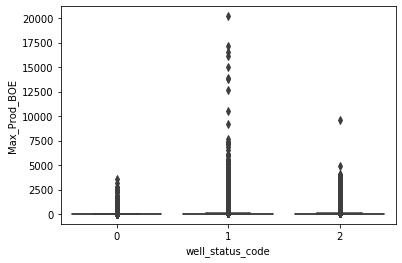

In [0]:
sns.boxplot(y='Max_Prod_BOE',x='''well_status_code''',data=df_train_processed, 
           )


#plt.ylim(0,5000)
#plt.xlim(0,5000)
;


In [0]:
# Lets change BOE to continues!
df_train_processed['Max_Prod_BOE'] = df_train_processed['Max_Prod_BOE'].where(df_train_processed['Max_Prod_BOE'].isnull(), 1).where(df_train_processed['Max_Prod_BOE'].notnull(), 0)
# Seems it didnt work! Back to binary
#df_train_processed['Max_Prod_BOE'] = df_train_processed['Max_Prod_BOE'].where(df_train_processed['Max_Prod_BOE'].notnull(), 0)
df_train_processed['Max_Prod_BOE'].describe() 

count    720804.000000
mean          0.316054
std           0.464935
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Max_Prod_BOE, dtype: float64

In [0]:
df_train_processed['Pool'] = df_train_processed['Pool'].where(df_train_processed['Pool']=='Unspecified', 1).where(df_train_processed['Pool']!='Unspecified', 0)

In [0]:
df_train_processed['SurfAbandonDate'] = df_train_processed['SurfAbandonDate'].where(df_train_processed['SurfAbandonDate'].isnull(), 1).where(df_train_processed['SurfAbandonDate'].notnull(), 0)

In [0]:
# Merge All BC data together
df_train_processed['PSACAreaCode']=df_train_processed['PSACAreaCode'].where((df_train_processed['PSACAreaCode']!='BC0') & 
                                         (df_train_processed['PSACAreaCode']!='BC1') &
                                         (df_train_processed['PSACAreaCode']!='BC2') &
                                         (df_train_processed['PSACAreaCode']!='BC3'), 'BC')
df_train_processed['PSACAreaCode'].unique()

array(['AB2', 'AB4', 'SK1', 'BC', 'SK3', 'AB3', 'AB7', 'AB6', 'AB5',
       'SK2', 'MB', 'AB1'], dtype=object)

In [0]:
df_train_processed['PSACAreaCode'].nunique()

12

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 13 columns):
well_status_code         720804 non-null int64
SurfAbandonDate          720804 non-null object
Pool                     720804 non-null object
DaysDrilling             720804 non-null float64
PSACAreaCode             720804 non-null object
Max_Prod_BOE             720804 non-null float64
Cur_Op_Par_size          720804 non-null object
My_Well_Types            720804 non-null object
Operator_is_Licensee     720804 non-null float64
Status_to_today          720804 non-null float64
Rig_release_to_Status    720804 non-null float64
Spud_to_rig_release      720804 non-null float64
HorizontalLegnth         720804 non-null float64
dtypes: float64(7), int64(1), object(5)
memory usage: 71.5+ MB


In [0]:
df_train_processed.dropna(inplace=True)
df_train_processed.reset_index(inplace=True)
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 14 columns):
index                    720804 non-null int64
well_status_code         720804 non-null int64
SurfAbandonDate          720804 non-null object
Pool                     720804 non-null object
DaysDrilling             720804 non-null float64
PSACAreaCode             720804 non-null object
Max_Prod_BOE             720804 non-null float64
Cur_Op_Par_size          720804 non-null object
My_Well_Types            720804 non-null object
Operator_is_Licensee     720804 non-null float64
Status_to_today          720804 non-null float64
Rig_release_to_Status    720804 non-null float64
Spud_to_rig_release      720804 non-null float64
HorizontalLegnth         720804 non-null float64
dtypes: float64(7), int64(2), object(5)
memory usage: 77.0+ MB


In [0]:

df_train_processed['well_status_code'] = df_train_processed['well_status_code'].astype('int8')
df_train_processed['SurfAbandonDate'] = df_train_processed['SurfAbandonDate'].astype('int8')
df_train_processed['Max_Prod_BOE'] = df_train_processed['Max_Prod_BOE'].astype('int8')

df_train_processed['Pool'] = df_train_processed['Pool'].astype('category')
df_train_processed['PSACAreaCode'] = df_train_processed['PSACAreaCode'].astype('category')
df_train_processed['My_Well_Types'] = df_train_processed['My_Well_Types'].astype('category')
df_train_processed['Cur_Op_Par_size'] = df_train_processed['Cur_Op_Par_size'].astype('category')
#df_train_processed['Operator_is_Licensee'] = df_train_processed['Operator_is_Licensee'].astype('category')


TVD_ss = RobustScaler()
df_train_processed['Status_to_today']= TVD_ss.fit_transform(df_train_processed[['Status_to_today']])
df_train_processed['Spud_to_rig_release']= TVD_ss.fit_transform(df_train_processed[['Spud_to_rig_release']])
df_train_processed['Rig_release_to_Status']= TVD_ss.fit_transform(df_train_processed[['Rig_release_to_Status']])
df_train_processed['HorizontalLegnth']= TVD_ss.fit_transform(df_train_processed[['HorizontalLegnth']])
df_train_processed['DaysDrilling']= TVD_ss.fit_transform(df_train_processed[['DaysDrilling']])
#df_train_processed['Max_Prod_BOE']= TVD_ss.fit_transform(df_train_processed[['Max_Prod_BOE']])


In [0]:
df_train_processed['Status_to_today'].describe()

count    720804.000000
mean          0.241005
std           0.847133
min          -0.793534
25%          -0.393101
50%           0.000000
75%           0.606899
max           2.202466
Name: Status_to_today, dtype: float64

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 14 columns):
index                    720804 non-null int64
well_status_code         720804 non-null int8
SurfAbandonDate          720804 non-null int8
Pool                     720804 non-null category
DaysDrilling             720804 non-null float64
PSACAreaCode             720804 non-null category
Max_Prod_BOE             720804 non-null int8
Cur_Op_Par_size          720804 non-null category
My_Well_Types            720804 non-null category
Operator_is_Licensee     720804 non-null float64
Status_to_today          720804 non-null float64
Rig_release_to_Status    720804 non-null float64
Spud_to_rig_release      720804 non-null float64
HorizontalLegnth         720804 non-null float64
dtypes: category(4), float64(6), int64(1), int8(3)
memory usage: 43.3 MB


In [0]:
df_train_processed.nunique()

index                    720804
well_status_code              3
SurfAbandonDate               2
Pool                          2
DaysDrilling               1876
PSACAreaCode                 12
Max_Prod_BOE                  2
Cur_Op_Par_size               9
My_Well_Types                17
Operator_is_Licensee          2
Status_to_today           17841
Rig_release_to_Status     13776
Spud_to_rig_release        1888
HorizontalLegnth          95012
dtype: int64

In [0]:
df_train_processed.head()

,index,well_status_code,SurfAbandonDate,Pool,DaysDrilling,PSACAreaCode,Max_Prod_BOE,Cur_Op_Par_size,My_Well_Types,Operator_is_Licensee,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth
0,0,2,0,1,0.375,AB2,0,Mid_Co,Gas,1.0,0.129812,3.954268,0.500,0.000000
1,1,1,0,1,-0.250,AB4,1,159,Bitumen,1.0,-0.280953,0.035569,-0.250,63.702345
2,2,0,0,1,-0.250,SK1,0,334,Oil,1.0,-0.323946,0.000000,-0.125,0.000000
3,3,0,0,1,-0.125,AB4,0,1108,Oil,0.0,1.151141,0.000000,-0.500,0.000000
4,4,2,0,0,0.750,BC,0,Small_Co,Unspecified,1.0,-0.638227,0.208333,0.750,0.000000


In [0]:
df_train_processed = pd.get_dummies(df_train_processed, drop_first=True)
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 46 columns):
index                                 720804 non-null int64
well_status_code                      720804 non-null int8
SurfAbandonDate                       720804 non-null int8
DaysDrilling                          720804 non-null float64
Max_Prod_BOE                          720804 non-null int8
Operator_is_Licensee                  720804 non-null float64
Status_to_today                       720804 non-null float64
Rig_release_to_Status                 720804 non-null float64
Spud_to_rig_release                   720804 non-null float64
HorizontalLegnth                      720804 non-null float64
Pool_1                                720804 non-null uint8
PSACAreaCode_AB2                      720804 non-null uint8
PSACAreaCode_AB3                      720804 non-null uint8
PSACAreaCode_AB4                      720804 non-null uint8
PSACAreaCode_AB5                      72

In [0]:
df_train_processed.head()

,index,well_status_code,SurfAbandonDate,DaysDrilling,Max_Prod_BOE,Operator_is_Licensee,Status_to_today,Rig_release_to_Status,Spud_to_rig_release,HorizontalLegnth,Pool_1,PSACAreaCode_AB2,PSACAreaCode_AB3,PSACAreaCode_AB4,PSACAreaCode_AB5,PSACAreaCode_AB6,PSACAreaCode_AB7,PSACAreaCode_BC,PSACAreaCode_MB,PSACAreaCode_SK1,PSACAreaCode_SK2,PSACAreaCode_SK3,Cur_Op_Par_size_168,Cur_Op_Par_size_334,Cur_Op_Par_size_1108,Cur_Op_Par_size_9608,Cur_Op_Par_size_9689,Cur_Op_Par_size_Mid_Co,Cur_Op_Par_size_Small_Co,Cur_Op_Par_size_Tiny_Co,My_Well_Types_Bitumen - Cyclical,My_Well_Types_Coalbed Methane,My_Well_Types_Commingled,My_Well_Types_Commingled Gas,My_Well_Types_Commingled_OG,My_Well_Types_Disposal - Water,My_Well_Types_Drain,My_Well_Types_Gas,My_Well_Types_Injection - Water,My_Well_Types_Observation,My_Well_Types_Oil,My_Well_Types_Oil Sands Evaluation,My_Well_Types_Other_Smalls,My_Well_Types_SAGD,My_Well_Types_Test Hole,My_Well_Types_Unspecified
0,0,2,0,0.375,0,1.0,0.129812,3.954268,0.500,0.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,-0.250,1,1.0,-0.280953,0.035569,-0.250,63.702345,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,-0.250,0,1.0,-0.323946,0.000000,-0.125,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,3,0,0,-0.125,0,0.0,1.151141,0.000000,-0.500,0.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,4,2,0,0.750,0,1.0,-0.638227,0.208333,0.750,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
df_train_processed['well_status_code'].unique()

array([2, 1, 0])

## Establish New baseline


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_train_processed.drop('well_status_code', axis=1), df_train_processed['well_status_code'], test_size=0.3)

In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504562 entries, 92538 to 714758
Data columns (total 45 columns):
index                                 504562 non-null int64
SurfAbandonDate                       504562 non-null int8
DaysDrilling                          504562 non-null float64
Max_Prod_BOE                          504562 non-null int8
Operator_is_Licensee                  504562 non-null float64
Status_to_today                       504562 non-null float64
Rig_release_to_Status                 504562 non-null float64
Spud_to_rig_release                   504562 non-null float64
HorizontalLegnth                      504562 non-null float64
Pool_1                                504562 non-null uint8
PSACAreaCode_AB2                      504562 non-null uint8
PSACAreaCode_AB3                      504562 non-null uint8
PSACAreaCode_AB4                      504562 non-null uint8
PSACAreaCode_AB5                      504562 non-null uint8
PSACAreaCode_AB6                   

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(900, activation='relu', input_shape=[len(X_train.keys())]),
  tf.keras.layers.Dense(900, activation='relu'),
  tf.keras.layers.Dense(90, activation='relu'),
  tf.keras.layers.Dense(3, activation = 'softmax' )
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=10, batch_size = 512, 
          validation_split = 0.2,
          callbacks=[EarlyStopping(monitor='loss',
                                   patience=1)])



Train on 403649 samples, validate on 100913 samples
Epoch 1/10
403649/403649 [==============================] - 7s 16us/sample - loss: 9.7319 - accuracy: 0.3962 - val_loss: 9.2059 - val_accuracy: 0.4288
Epoch 2/10
403649/403649 [==============================] - 6s 16us/sample - loss: 9.2583 - accuracy: 0.4256 - val_loss: 9.2058 - val_accuracy: 0.4288
Epoch 3/10
403649/403649 [==============================] - 6s 16us/sample - loss: 9.8029 - accuracy: 0.3918 - val_loss: 9.7803 - val_accuracy: 0.3932


In [0]:
model.evaluate(X_test,  y_test, verbose=2)

216242/216242 - 13s - loss: 9.7613 - accuracy: 0.3944


[9.761284606105107, 0.3943776]

In [0]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train,)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
predictions = rf.predict(X_test)

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     92012
           1       0.94      0.96      0.95     85473
           2       0.86      0.81      0.84     38757

    accuracy                           0.93    216242
   macro avg       0.92      0.91      0.92    216242
weighted avg       0.93      0.93      0.93    216242



## Other Models
- Offered no improvement over RF. They can use some parameters tuning though

In [0]:
GBM = GradientBoostingClassifier()
GBM.fit(X_train, y_train,)
predictions = GBM.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     92116
           1       0.92      0.93      0.93     85566
           2       0.79      0.77      0.78     38477

    accuracy                           0.91    216159
   macro avg       0.88      0.88      0.88    216159
weighted avg       0.91      0.91      0.91    216159



In [0]:
XGB_model = XGBClassifier(n_estimators=700, max_depth = 6, objective='multi:softmax')


In [0]:
XGB_model.fit(X_train, y_train,early_stopping_rounds=5,  eval_set=[(X_test, y_test)], verbose=False)

In [0]:
predictions = XGB_model.predict(X_test)
print(classification_report(y_test,predictions))


In [0]:
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.48      0.97      0.64     92116
           1       0.74      0.24      0.36     85566
           2       0.24      0.00      0.01     38477

    accuracy                           0.51    216159
   macro avg       0.49      0.40      0.33    216159
weighted avg       0.54      0.51      0.42    216159



In [0]:
gnb = naive_bayes.ComplementNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.49      0.95      0.65     92116
           1       0.70      0.30      0.42     85566
           2       0.49      0.01      0.02     38477

    accuracy                           0.53    216159
   macro avg       0.56      0.42      0.36    216159
weighted avg       0.57      0.53      0.45    216159



In [0]:
gnb = naive_bayes.MultinomialNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.51      0.93      0.66     92116
           1       0.72      0.27      0.39     85566
           2       0.27      0.10      0.15     38477

    accuracy                           0.52    216159
   macro avg       0.50      0.43      0.40    216159
weighted avg       0.55      0.52      0.46    216159



In [0]:
gnb = naive_bayes.BernoulliNB()
gnb.fit(X_train,y_train)
predictions = gnb.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     92116
           1       0.81      0.81      0.81     85566
           2       0.57      0.43      0.49     38477

    accuracy                           0.78    216159
   macro avg       0.73      0.71      0.72    216159
weighted avg       0.77      0.78      0.77    216159



In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(5130, activation='relu', input_shape=[len(X_train.keys())]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(5130, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(171, activation='relu'),
  tf.keras.layers.Dense(3, activation = 'softmax' )
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=5, batch_size = 512, 
          validation_split = 0.2,
          callbacks=[EarlyStopping(monitor='loss',
                                   patience=1)])



Train on 403495 samples, validate on 100874 samples
Epoch 1/5
403495/403495 [==============================] - 50s 124us/sample - loss: 1.9198 - accuracy: 0.4328 - val_loss: 2.9905 - val_accuracy: 0.3870
Epoch 2/5
403495/403495 [==============================] - 51s 126us/sample - loss: 1.0336 - accuracy: 0.4882 - val_loss: 2.7348 - val_accuracy: 0.3933
Epoch 3/5
403495/403495 [==============================] - 49s 122us/sample - loss: 1.0061 - accuracy: 0.5063 - val_loss: 1.7360 - val_accuracy: 0.4506
Epoch 4/5
269312/403495 [===================>..........] - ETA: 15s - loss: 0.9890 - accuracy: 0.5225

KeyboardInterrupt: ignored

## Model Optimization:


### Lets drop unnecessary inputs
to optimize the model, lets try to only keep the most releavant items

In [0]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720804 entries, 0 to 720803
Data columns (total 46 columns):
index                                 720804 non-null int64
well_status_code                      720804 non-null int8
SurfAbandonDate                       720804 non-null int8
DaysDrilling                          720804 non-null float64
Max_Prod_BOE                          720804 non-null int8
Operator_is_Licensee                  720804 non-null float64
Status_to_today                       720804 non-null float64
Rig_release_to_Status                 720804 non-null float64
Spud_to_rig_release                   720804 non-null float64
HorizontalLegnth                      720804 non-null float64
Pool_1                                720804 non-null uint8
PSACAreaCode_AB2                      720804 non-null uint8
PSACAreaCode_AB3                      720804 non-null uint8
PSACAreaCode_AB4                      720804 non-null uint8
PSACAreaCode_AB5                      72

In [0]:
df_train_processed.drop(['Rig_release_to_Status','Spud_to_rig_release'
                         ],
                         axis = 1, inplace=True);

### Random Search

In [0]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [0]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 60, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 257, 505, 752, 1000]}

In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10, scoring='accuracy', 
                              cv = 3, verbose=2, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 89.6min finished


In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 752}

In [0]:
#rf_random.cv_results_

In [0]:
best_random_model = rf_random.best_estimator_

In [0]:
predictions = best_random_model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     92292
           1       0.95      0.96      0.96     85281
           2       0.86      0.85      0.85     38669

    accuracy                           0.94    216242
   macro avg       0.93      0.92      0.92    216242
weighted avg       0.94      0.94      0.94    216242



### Grid Search


In [0]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [650, 750, 850]
}



# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [0]:
grid_search.fit(X_train, y_train);


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 127.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 306.9min finished


In [0]:
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 650}

In [0]:
best_grid_model = grid_search.best_estimator_


In [0]:
predictions = best_grid_model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     92292
           1       0.95      0.96      0.96     85281
           2       0.86      0.85      0.85     38669

    accuracy                           0.94    216242
   macro avg       0.93      0.92      0.92    216242
weighted avg       0.94      0.94      0.94    216242



### Second Round of Grid search

In [0]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [60],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [6,7],
    'n_estimators': [650]
}

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 10, n_jobs = -1, verbose = 4, return_train_score=True)

grid_search_final.fit(X_train, y_train);

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 86.4min finished


In [0]:
grid_search_final.best_params_


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 650}

In [0]:
best_grid_Model_final = grid_search_final.best_estimator_
predictions = best_grid_Model_final.predict(X_test)


NameError: ignored

In [0]:
grid_search_final.best_params_

NameError: ignored